## SARIMAX

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (20,5)  #defualt figure size

In [3]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

In [4]:
import time
from sklearn.metrics import mean_squared_error

In [5]:
from tqdm.notebook import tqdm as tqdm
import statsmodels.api as sm

In [4]:
sell_prices = pd.read_csv('sell_prices.csv')
calendar = pd.read_csv('calendar.csv')
sales = pd.read_csv('sales_train_evaluation.csv')
sample_output = pd.read_csv('sample_submission.csv')

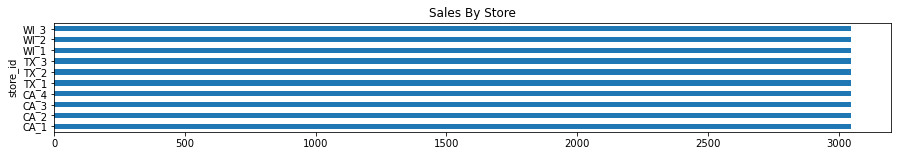

In [5]:
sales.groupby('store_id').count()['id'].sort_values().plot(kind='barh',figsize=(15,2), title='Sales By Store',width=0.5)
plt.show()

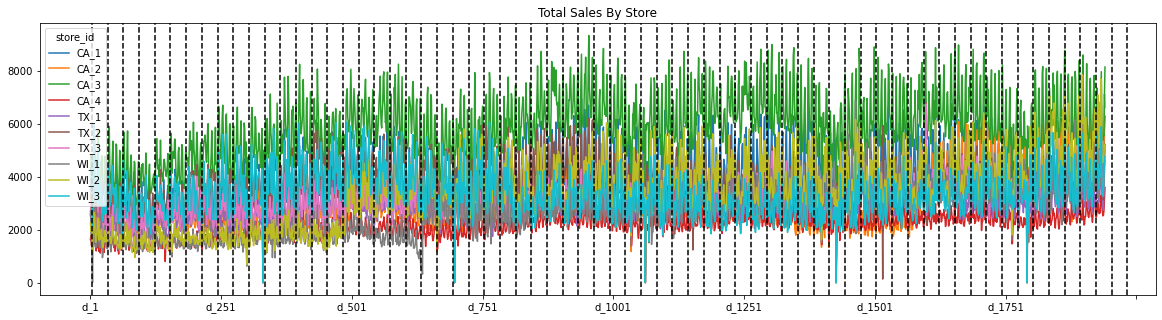

In [6]:
date_columns = [c for c in sales.columns if 'd_' in c] # select date columns
gouped_by_store_totals = sales.groupby(['store_id']).sum().T  #get sum and trasnpose
#print(gouped_by_cat_totals.columns)
gouped_by_store_totals.plot(figsize=(20,5),title="Total Sales By Store")
cal_columns = ['d','month']
monthPosition = np.arange(3,2000,30) #Roughly
for xc in monthPosition:
    plt.axvline(x=xc, color='k', linestyle='--')
plt.show()

In [7]:
data = gouped_by_store_totals
data.index = range(1,1942)
data = data.reset_index()

In [8]:
train = data[data['index'] <= 1913]
test = data[data['index'] > 1913]

In [9]:
def test_stationarityDF(timeseries): ##Dickey-Fuller Test
    dftest = adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','No of Observesations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [10]:
predictions = pd.DataFrame()
predictions['date'] = test['index']
stats = pd.DataFrame(columns=['Model Name','Execution Time','RMSE'])

In [6]:
train_val = pd.read_csv('sales_train_evaluation.csv')
d_cols = [c for c in train_val.columns if 'd_' in c]

In [22]:
train_val

id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_evaluation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_evaluation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_evaluation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_evaluation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_evaluation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  ...  d_1932  d_1933  d_1934  \
0         CA_1       CA    0    0    0    0  ...       2       4       0   
1         CA_1       CA    0    0    0    0  ...       0       1       2   
2         CA_1       CA    0    0    0    0  ...       1       0       2   
3         CA_1       CA    0    0    0    0  ...       1       1       0   
4         CA_1       CA    0    0    0    0  ...       0       0       0   
...        ...      ...  ...  ...  ...  ...  ...     ...     ...     ...   
30485     WI_3       WI    0    0    2    2  ...       1       0       3   
30486     WI_3       WI    0    0    0    0  ...       0       0       0   
30487     WI_3       WI    0    6    0    2  ...       0       0       1   
30488     WI_3       WI    0    0    0    0  ...       1       1       1   
30489     WI_3       WI    0    0    0    0  ...       1       2       0   

       d_1935  d_1936  d_1937  d_1938  d_1939  d_1940  d_1941  
0           0       0       0       3       3       0       1  
1           1       1       0       0       0       0       0  
2           0       0       0       2       3       0       1  
3           4       0       1       3       0       2       6  
4           2       1       0       0       2       1       0  
...       ...     ...     ...     ...     ...     ...     ...  
30485       0       1       1       0       0       1       1  
30486       0       0       0       1       0       1       0  
30487       2       0       1       0       1       0       2  
30488       4       6       0       1       1       1       0  
30489       5       4       0       2       2       5       1  

[30490 rows x 1947 columns]

### CA_1

In [25]:
ca1_Series 

d_1       4337
d_2       4155
d_3       2816
d_4       3051
d_5       2630
          ... 
d_1909    3722
d_1910    3709
d_1911    4387
d_1912    5577
d_1913    6113
Name: CA_1, Length: 1913, dtype: int64

Test Statistic                 -2.035408
p-value                         0.271267
#Lags Used                     26.000000
No of Observesations Used    1886.000000
Critical Value (1%)            -3.433822
Critical Value (5%)            -2.863074
Critical Value (10%)           -2.567586
dtype: float64


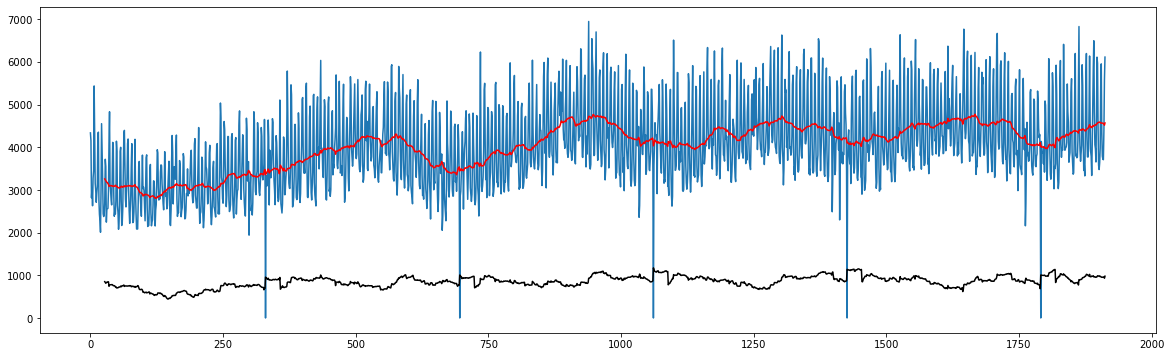

In [11]:
ca1_Series = train['CA_1']
ca1_Series.fillna(0,inplace=True)
test_stationarityDF(ca1_Series)

movingAverage = ca1_Series.rolling(window=28).mean()
movingSTD = ca1_Series.rolling(window=28).std()
plt.figure(figsize=(20,6))
plt.plot(ca1_Series)
plt.plot(movingAverage,color='red')
plt.plot(movingSTD,color='black')
plt.show()

#### According to p-value which is equal to 0.271267, we can get that the series is not stationary.

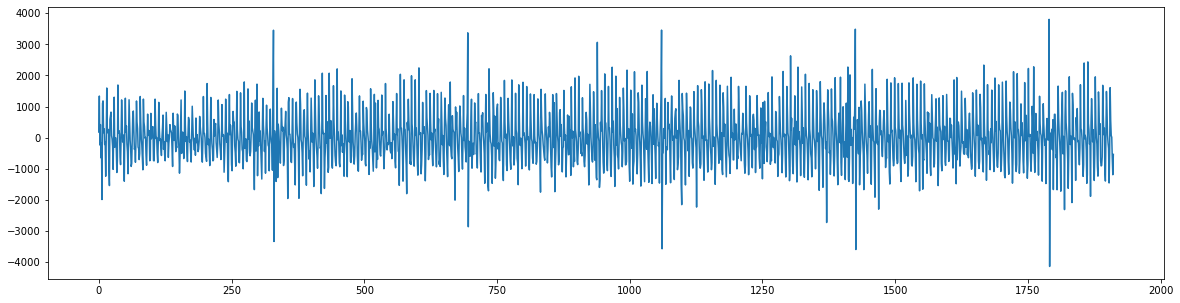

Test Statistic               -20.62601
p-value                        0.00000
#Lags Used                    26.00000
No of Observesations Used   1885.00000
Critical Value (1%)           -3.43382
Critical Value (5%)           -2.86307
Critical Value (10%)          -2.56759
dtype: float64


In [13]:
diff =[ ca1_Series[i]-ca1_Series[i+1] for i in range(len(ca1_Series)-1) ]
diff = pd.DataFrame(diff)
plt.figure(figsize=(20,5))
plt.plot(diff)
plt.show()
pd.set_option('display.float_format', '{:.5f}'.format)
diff.fillna(0,inplace=True)
test_stationarityDF(diff)


#### According to p-value which is equal to 0.00000, we can conculde that the above Series is 99.9% stationary.

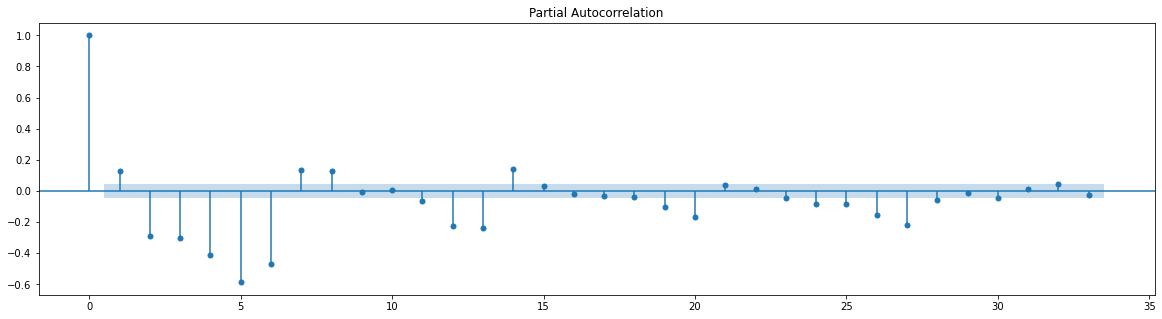

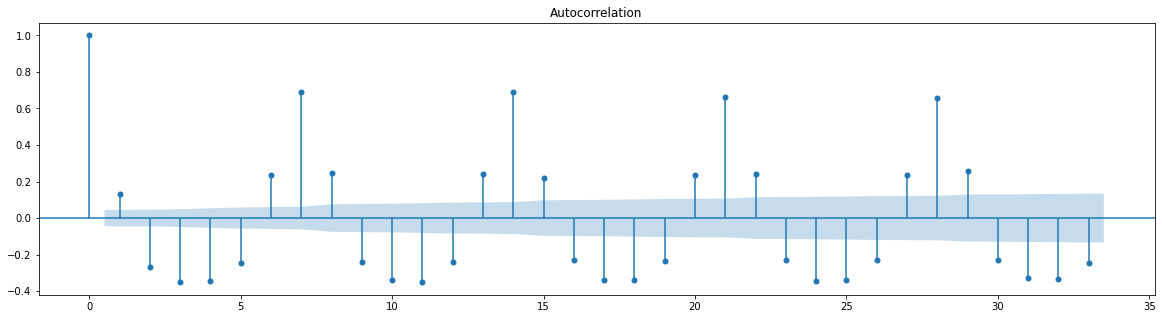

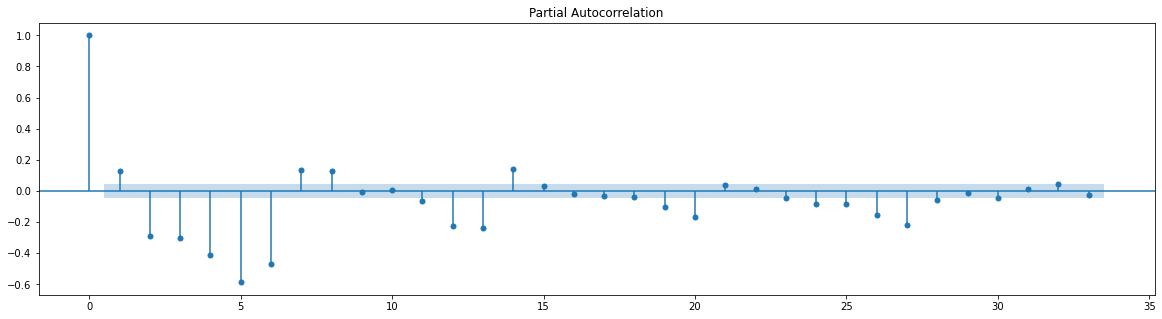

In [14]:
plot_acf(diff)
plot_pacf(diff)

In [16]:
t0 = time.time()
model_name='SARIMA_ca1'
sarima_model = auto_arima(ca1_Series, start_p=0, start_q=0,
                          max_p=5, max_q=5,
                          seasonal=True, m=7,
                          d=None, trace=True,random_state=2020,
                          out_of_sample_size=28,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
sarima_model.summary() 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.53 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=31295.082, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=29891.705, Time=1.11 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=30665.564, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=31293.083, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=31263.989, Time=0.17 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=29503.943, Time=3.20 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=3.19 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=3.75 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=29704.192, Time=1.56 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=29401.045, Time=3.07 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=29806.321, Time=1.48 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=4.69 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=3.64 sec
 ARIMA(3,1,0)(2,0,0)[7] intercept   : AIC=29339.2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1913
Model:             SARIMAX(5, 1, 0)x(1, 0, [1], 7)   Log Likelihood              -14449.540
Date:                             Sat, 11 Dec 2021   AIC                          28917.080
Time:                                     15:16:57   BIC                          28967.083
Sample:                                          0   HQIC                         28935.482
                                            - 1913                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0289      0.173      0.166      0.868      -0.311       0.369
ar.L1         -0.5310      0.015    -35.198      0.000      -0.561      -0.501
ar.L2         -0.4355      0.022    -19.586      0.000      -0.479      -0.392
ar.L3         -0.3297      0.028    -11.669      0.000      -0.385      -0.274
ar.L4         -0.2571      0.025    -10.161      0.000      -0.307      -0.208
ar.L5         -0.1839      0.022     -8.291      0.000      -0.227      -0.140
ar.S.L7        0.9998      0.000   7852.106      0.000       1.000       1.000
ma.S.L7       -0.9221      0.013    -72.897      0.000      -0.947      -0.897
sigma2      2.594e+05   2.34e-07   1.11e+12      0.000    2.59e+05    2.59e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.84   Jarque-Bera (JB):             15849.42
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                            -1.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.83e+26. Standard errors may be unstable.
"""

RMSE for SARIMA_ca1: 335.0614


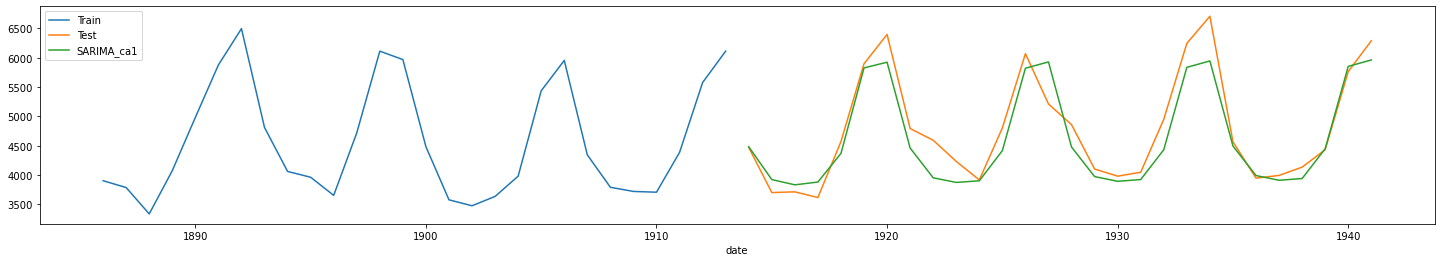

In [57]:
#train
sarima_model.fit(ca1_Series)
t1 = time.time()-t0
#predict
predictions[model_name] = sarima_model.predict(n_periods=28)
#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='index',y='CA_1',label='Train',ax=ax)
test.plot(x='index',y='CA_1',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['CA_1']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)

In [58]:
stats

Model Name  Execution Time      RMSE
0  SARIMA_ca1       138.96155 335.06142

In [7]:
data_ca1 = train_val[train_val['store_id'] == "CA_1"]

In [8]:
train_data= data_ca1[d_cols[:-28]]
val_data = data_ca1[d_cols[-28:]]

In [10]:
predictions = []
for row in tqdm(train_data[train_data.columns[-28:]].values[:3049]):
    fit = sm.tsa.statespace.SARIMAX(row,order=(5,1,0), seasonal_order=(1, 0, 1, 7),enforce_stationarity=False).fit()
    predictions.append(fit.forecast(28))
predictions = np.array(predictions).reshape((-1, 28))

  0%|          | 0/3049 [00:00<?, ?it/s]

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

In [11]:
predictions

array([[ 8.34372971e-01,  1.11294640e+00,  5.42942475e-01, ...,
         9.32186635e-01,  9.41251929e-01,  9.36883411e-01],
       [ 1.00000117e+00, -1.58373886e-06, -3.07140248e-07, ...,
         1.00000699e+00, -9.50247667e-06, -2.03701796e-06],
       [ 1.26944665e+00,  1.14961298e+00,  1.03195753e+00, ...,
         8.21403485e-01,  8.23259889e-01,  8.20429116e-01],
       ...,
       [ 1.12386302e+00,  3.08508532e+00,  3.68203750e+00, ...,
         1.86719068e+00,  2.32436345e+00,  2.94931074e+00],
       [ 9.80762182e-01, -2.96786765e-01,  1.91927639e+00, ...,
         1.07491695e+00,  9.43443934e-01,  8.34887569e-01],
       [ 1.32406667e+01, -6.30390457e+00, -2.62545370e+00, ...,
        -1.67947958e+01, -2.01984391e+01,  3.52528648e+00]])

In [12]:
rmse_ca1 = np.sqrt(mean_squared_error(predictions[:3049], val_data.values[:3049]))

In [13]:
rmse_ca1

5.902990976257626e+105

### CA_2

Test Statistic                -0.54014
p-value                        0.88394
#Lags Used                    26.00000
No of Observesations Used   1886.00000
Critical Value (1%)           -3.43382
Critical Value (5%)           -2.86307
Critical Value (10%)          -2.56759
dtype: float64


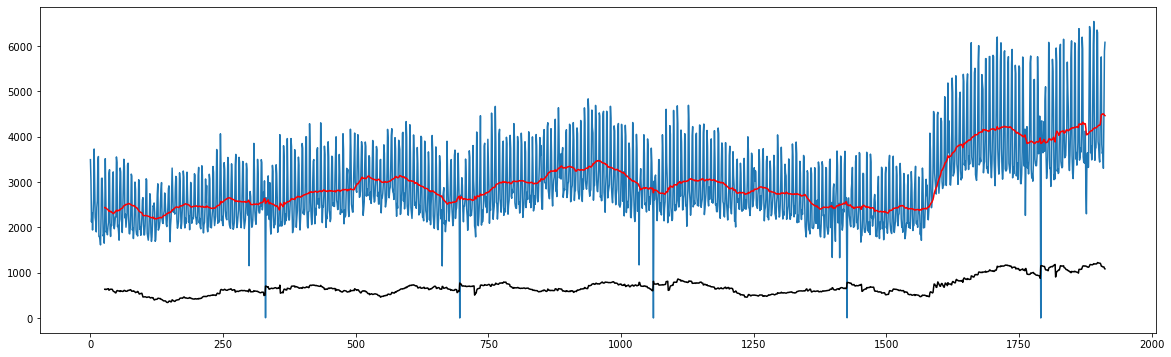

In [160]:
ca1_Series = train['CA_2']
ca1_Series.fillna(0,inplace=True)
test_stationarityDF(ca1_Series)

movingAverage = ca1_Series.rolling(window=28).mean()
movingSTD = ca1_Series.rolling(window=28).std()
plt.figure(figsize=(20,6))
plt.plot(ca1_Series)
plt.plot(movingAverage,color='red')
plt.plot(movingSTD,color='black')
plt.show()

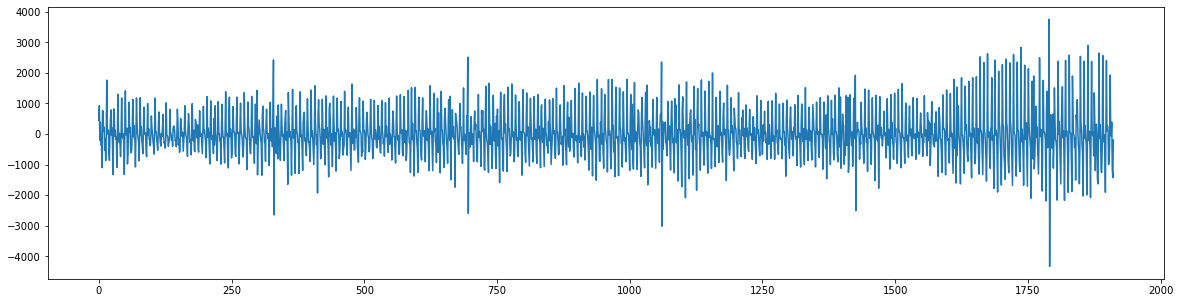

Test Statistic               -15.08962
p-value                        0.00000
#Lags Used                    26.00000
No of Observesations Used   1885.00000
Critical Value (1%)           -3.43382
Critical Value (5%)           -2.86307
Critical Value (10%)          -2.56759
dtype: float64


In [161]:
diff =[ ca1_Series[i]-ca1_Series[i+1] for i in range(len(ca1_Series)-1) ]
diff = pd.DataFrame(diff)
plt.figure(figsize=(20,5))
plt.plot(diff)
plt.show()
pd.set_option('display.float_format', '{:.5f}'.format)
ca1SeriesDiff.fillna(0,inplace=True)
test_stationarityDF(diff)

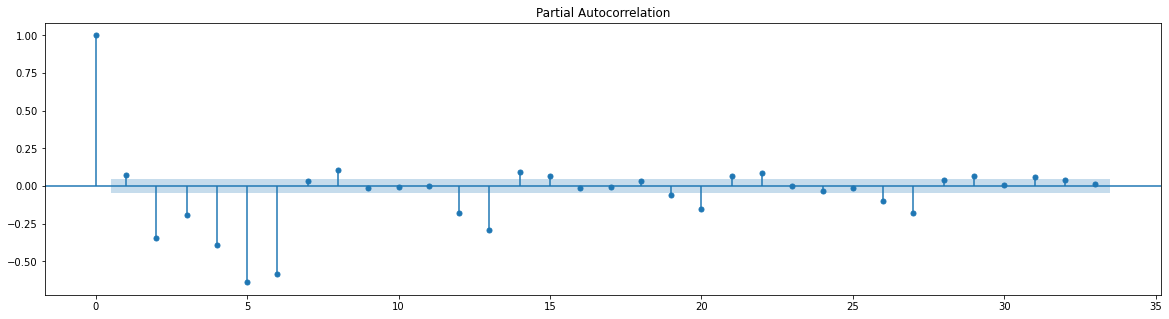

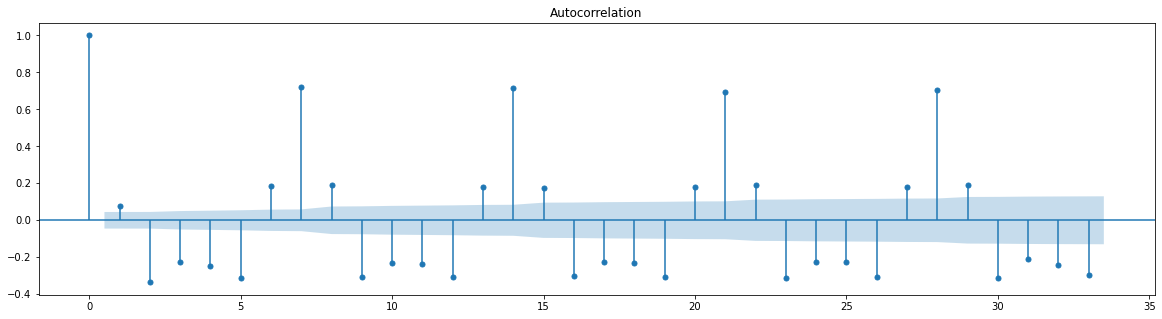

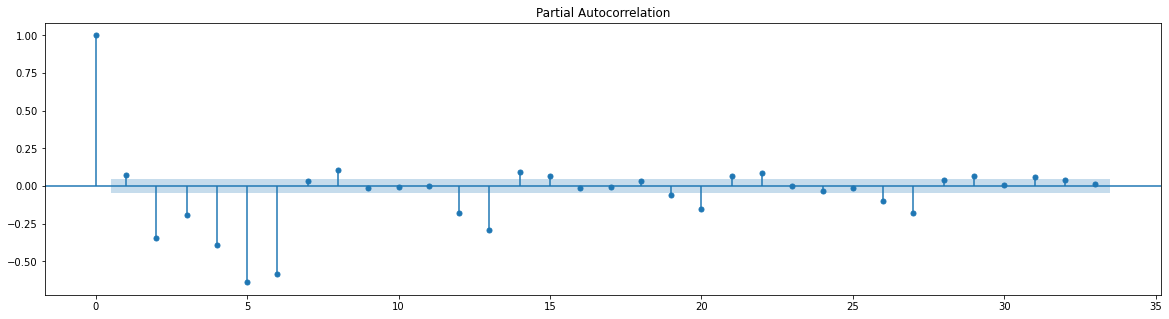

In [162]:
plot_acf(diff)
plot_pacf(diff)

In [60]:
t0 = time.time()
model_name='SARIMA_ca2'
sarima_model = auto_arima(ca1_Series, start_p=0, start_q=0,
                          max_p=5, max_q=5,
                          seasonal=True, m=7,
                          d=None, trace=True,random_state=2020,
                          out_of_sample_size=28,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
sarima_model.summary() 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=28607.823, Time=1.38 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=30785.826, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=29125.971, Time=1.28 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=29689.810, Time=1.38 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=30783.833, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=30089.828, Time=0.58 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=29373.848, Time=0.57 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.55 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=2.42 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=29707.761, Time=1.33 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=29005.640, Time=1.65 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=8.50 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=28310.884, Time=1.74 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=30075.613, Time=1.01 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   :

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1913
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 7)   Log Likelihood              -13855.480
Date:                             Sat, 11 Dec 2021   AIC                          27722.960
Time:                                     01:33:11   BIC                          27756.296
Sample:                                          0   HQIC                         27735.228
                                            - 1913                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0011      0.016     -0.067      0.946      -0.033       0.030
ma.L1         -0.7378      0.010    -74.405      0.000      -0.757      -0.718
ma.L2         -0.1781      0.012    -14.292      0.000      -0.203      -0.154
ar.S.L7        0.9997      0.000   4225.290      0.000       0.999       1.000
ma.S.L7       -0.9102      0.007   -122.796      0.000      -0.925      -0.896
sigma2      1.136e+05   1154.439     98.440      0.000    1.11e+05    1.16e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             49404.51
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.35   Skew:                            -2.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE for SARIMA_ca2: 427.5025


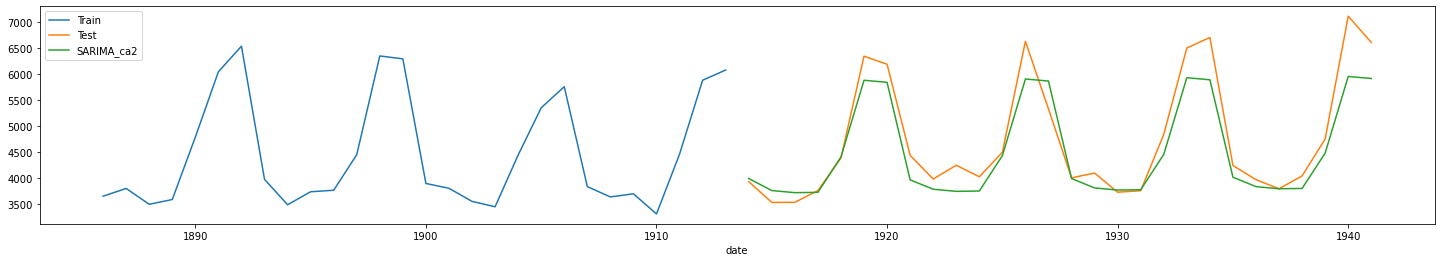

In [62]:
#train
sarima_model.fit(ca1_Series)
t1 = time.time()-t0
#predict
predictions[model_name] = sarima_model.predict(n_periods=28)
#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='index',y='CA_2',label='Train',ax=ax)
test.plot(x='index',y='CA_2',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['CA_2']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)

In [63]:
stats

Model Name  Execution Time      RMSE
0  SARIMA_ca1       138.96155 335.06142
1  SARIMA_ca2       200.47475 427.50246

In [14]:
data_ca2 = train_val[train_val['store_id'] == "CA_2"]
train_data= data_ca2[d_cols[:-28]]
val_data = data_ca2[d_cols[-28:]]

predictions = []
for row in tqdm(train_data[train_data.columns[-28:]].values[:3049]):
    fit = sm.tsa.statespace.SARIMAX(row,order=(0,1,2), seasonal_order=(1, 0, 1, 7),enforce_stationarity=False).fit()
    predictions.append(fit.forecast(28))
predictions = np.array(predictions).reshape((-1, 28))

rmse_ca2 = np.sqrt(mean_squared_error(predictions[:3049], val_data.values[:3049]))

  0%|          | 0/3049 [00:00<?, ?it/s]

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

In [15]:
rmse_ca2

2.8007972230487996

## CA_3

Test Statistic                -2.39716
p-value                        0.14254
#Lags Used                    26.00000
No of Observesations Used   1886.00000
Critical Value (1%)           -3.43382
Critical Value (5%)           -2.86307
Critical Value (10%)          -2.56759
dtype: float64


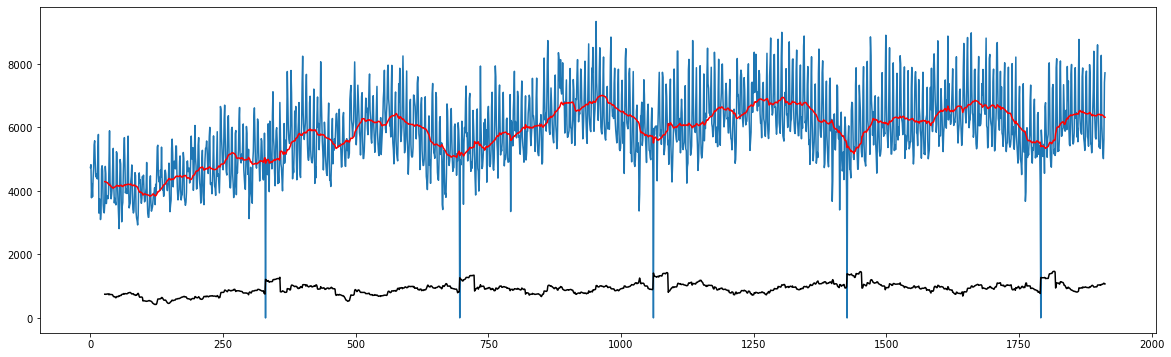

In [157]:
ca1_Series = train['CA_3']
ca1_Series.fillna(0,inplace=True)
test_stationarityDF(ca1_Series)

movingAverage = ca1_Series.rolling(window=28).mean()
movingSTD = ca1_Series.rolling(window=28).std()
plt.figure(figsize=(20,6))
plt.plot(ca1_Series)
plt.plot(movingAverage,color='red')
plt.plot(movingSTD,color='black')
plt.show()

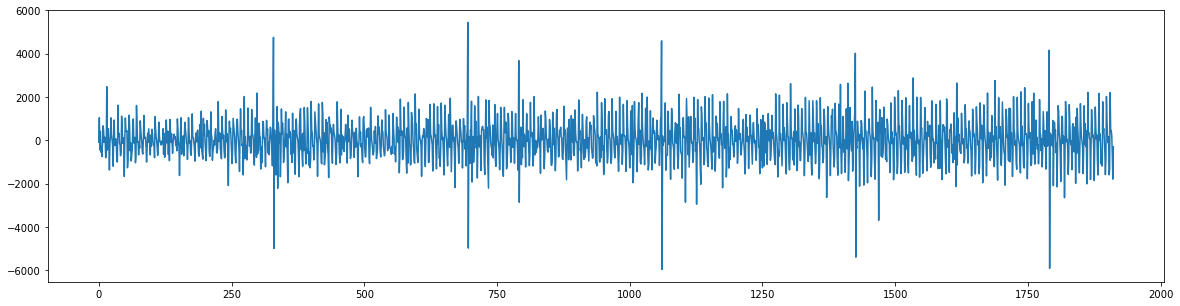

Test Statistic               -20.33729
p-value                        0.00000
#Lags Used                    26.00000
No of Observesations Used   1885.00000
Critical Value (1%)           -3.43382
Critical Value (5%)           -2.86307
Critical Value (10%)          -2.56759
dtype: float64


In [158]:
diff =[ ca1_Series[i]-ca1_Series[i+1] for i in range(len(ca1_Series)-1) ]
diff = pd.DataFrame(diff)
plt.figure(figsize=(20,5))
plt.plot(diff)
plt.show()
pd.set_option('display.float_format', '{:.5f}'.format)
ca1SeriesDiff.fillna(0,inplace=True)
test_stationarityDF(diff)

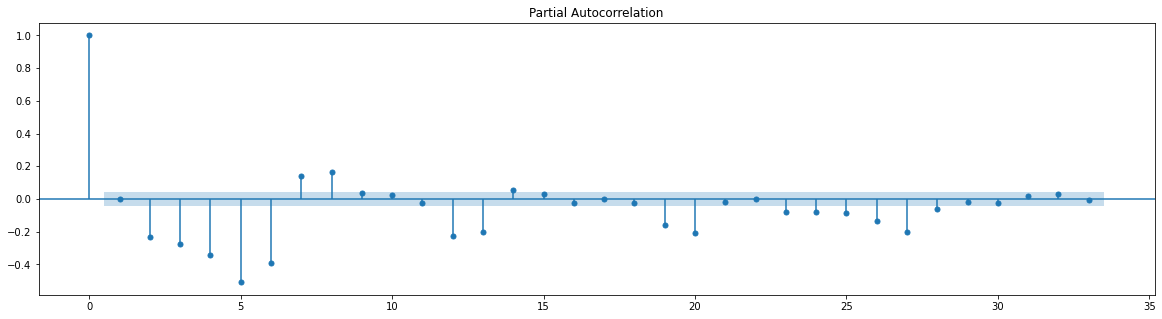

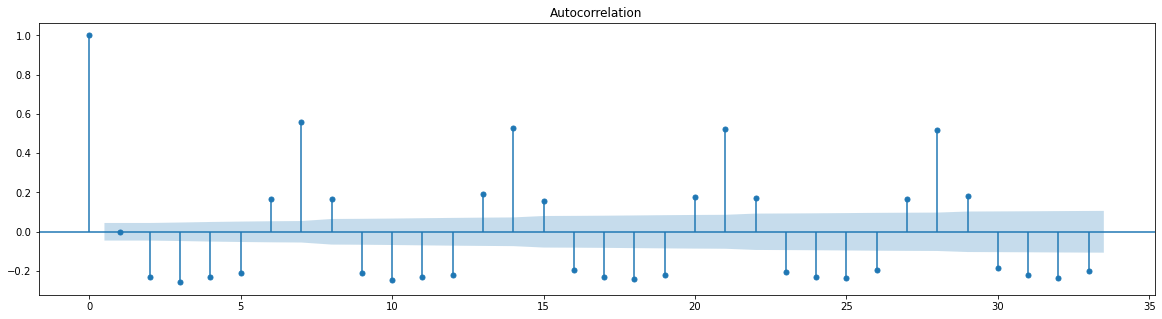

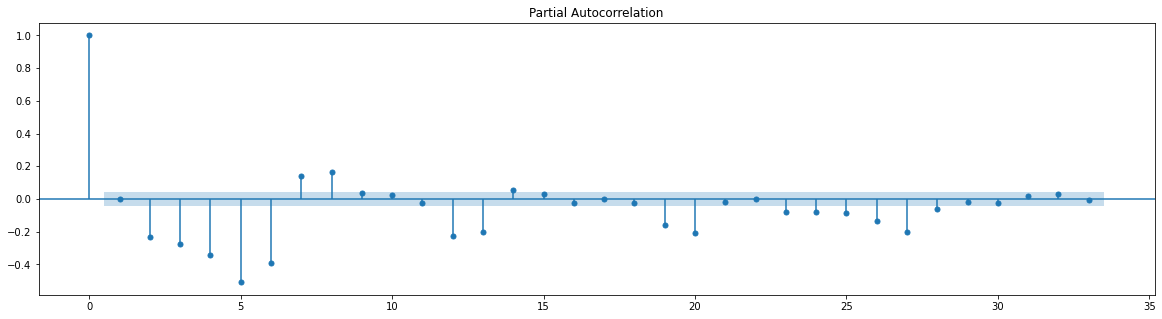

In [159]:
plot_acf(diff)
plot_pacf(diff)

In [67]:
t0 = time.time()
model_name='SARIMA_ca3'
sarima_model = auto_arima(ca1_Series, start_p=0, start_q=0,
                          max_p=5, max_q=5,
                          seasonal=True, m=7,
                          d=None, trace=True,random_state=2020,
                          out_of_sample_size=28,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
sarima_model.summary() 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.39 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=31696.872, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=30804.707, Time=0.95 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=31112.647, Time=1.44 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=31694.882, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=31698.867, Time=0.18 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=30550.741, Time=2.13 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=4.31 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=30778.935, Time=1.31 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=30464.052, Time=2.72 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=30724.932, Time=1.33 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=5.72 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.79 sec
 ARIMA(3,1,0)(2,0,0)[7] intercept   : AIC=30387.3

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1913
Model:             SARIMAX(3, 1, 0)x(1, 0, [1], 7)   Log Likelihood              -15060.361
Date:                             Sat, 11 Dec 2021   AIC                          30134.722
Time:                                     01:36:23   BIC                          30173.614
Sample:                                          0   HQIC                         30149.035
                                            - 1913                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -22.0023      4.390     -5.012      0.000     -30.606     -13.398
ar.L1         -0.4925      0.013    -37.471      0.000      -0.518      -0.467
ar.L2         -0.3158      0.025    -12.462      0.000      -0.365      -0.266
ar.L3         -0.1976      0.028     -7.143      0.000      -0.252      -0.143
ar.S.L7        0.9771      0.005    184.983      0.000       0.967       0.987
ma.S.L7       -0.7702      0.022    -35.741      0.000      -0.812      -0.728
sigma2      5.142e+05   9000.825     57.133      0.000    4.97e+05    5.32e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.38   Jarque-Bera (JB):             11524.68
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE for SARIMA_ca3: 1276.1362


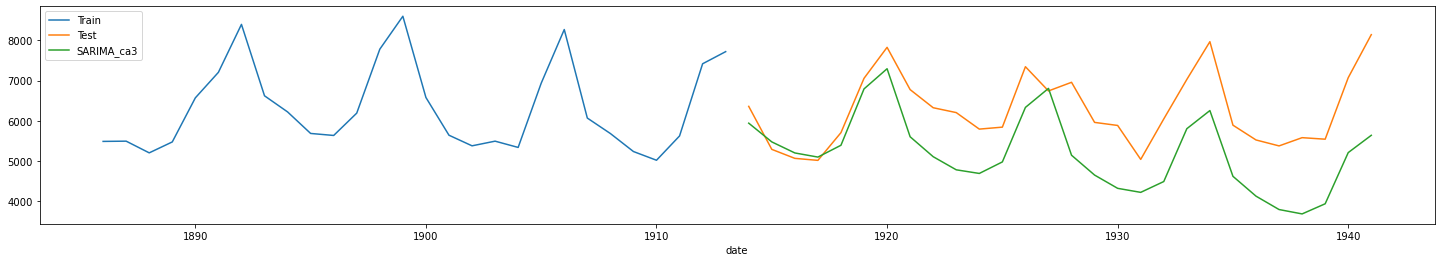

In [68]:
#train
sarima_model.fit(ca1_Series)
t1 = time.time()-t0
#predict
predictions[model_name] = sarima_model.predict(n_periods=28)
#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='index',y='CA_3',label='Train',ax=ax)
test.plot(x='index',y='CA_3',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['CA_3']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)

In [69]:
stats

Model Name  Execution Time       RMSE
0  SARIMA_ca1       138.96155  335.06142
1  SARIMA_ca2       200.47475  427.50246
2  SARIMA_ca3        93.88282 1276.13620

In [39]:
data_ca3 = train_val[train_val['store_id'] == "CA_3"]
train_data= data_ca3[d_cols[:-28]]
val_data = data_ca3[d_cols[-28:]]

predictions = []
for row in tqdm(train_data[train_data.columns[-28:]].values[:3049]):
    fit = sm.tsa.statespace.SARIMAX(row, seasonal_order=(1, 0, 1, 7)).fit()
    predictions.append(fit.forecast(28))
predictions = np.array(predictions).reshape((-1, 28))

rmse_ca3 = np.sqrt(mean_squared_error(predictions[:3049], val_data.values[:3049]))

  0%|          | 0/3049 [00:00<?, ?it/s]

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

In [40]:
rmse_ca3

3.284792314168772

## CA_4

Test Statistic                -1.78755
p-value                        0.38666
#Lags Used                    26.00000
No of Observesations Used   1886.00000
Critical Value (1%)           -3.43382
Critical Value (5%)           -2.86307
Critical Value (10%)          -2.56759
dtype: float64


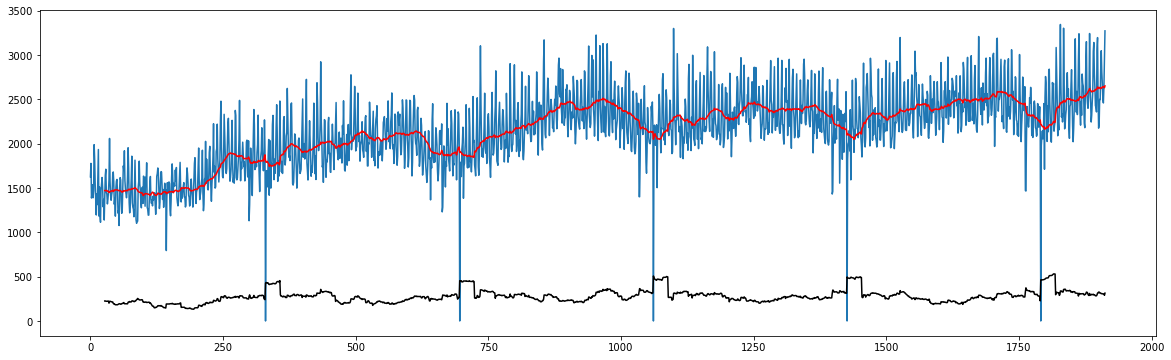

In [154]:
ca1_Series = train['CA_4']
ca1_Series.fillna(0,inplace=True)
test_stationarityDF(ca1_Series)

movingAverage = ca1_Series.rolling(window=28).mean()
movingSTD = ca1_Series.rolling(window=28).std()
plt.figure(figsize=(20,6))
plt.plot(ca1_Series)
plt.plot(movingAverage,color='red')
plt.plot(movingSTD,color='black')
plt.show()

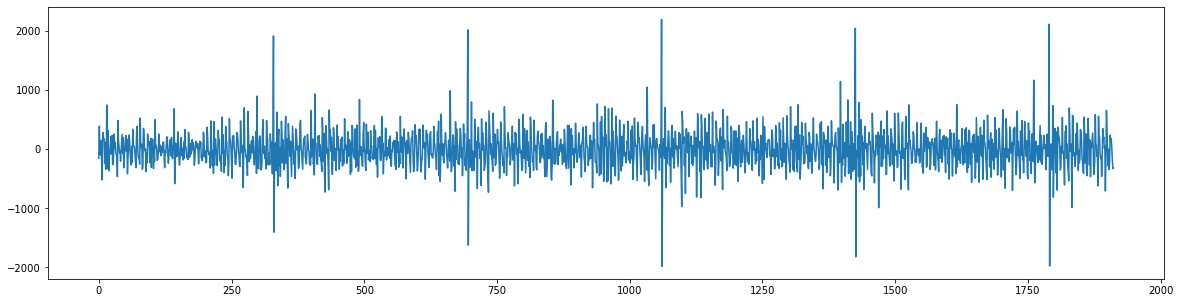

Test Statistic               -16.32092
p-value                        0.00000
#Lags Used                    26.00000
No of Observesations Used   1885.00000
Critical Value (1%)           -3.43382
Critical Value (5%)           -2.86307
Critical Value (10%)          -2.56759
dtype: float64


In [155]:
diff =[ ca1_Series[i]-ca1_Series[i+1] for i in range(len(ca1_Series)-1) ]
diff = pd.DataFrame(diff)
plt.figure(figsize=(20,5))
plt.plot(diff)
plt.show()
pd.set_option('display.float_format', '{:.5f}'.format)
ca1SeriesDiff.fillna(0,inplace=True)
test_stationarityDF(diff)

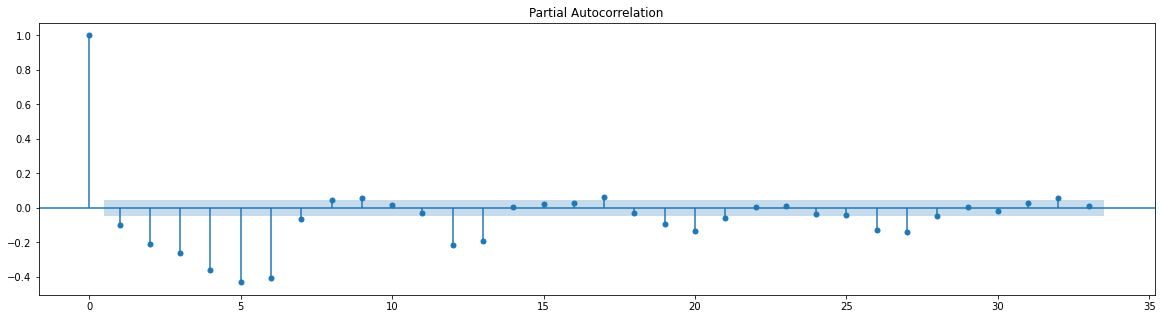

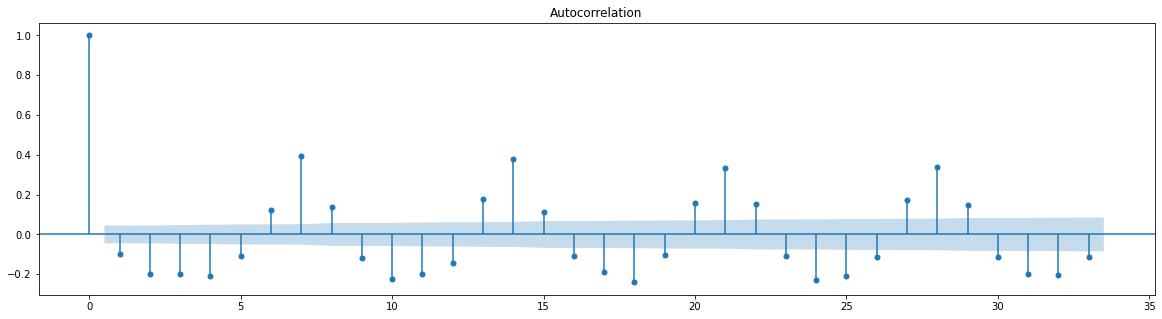

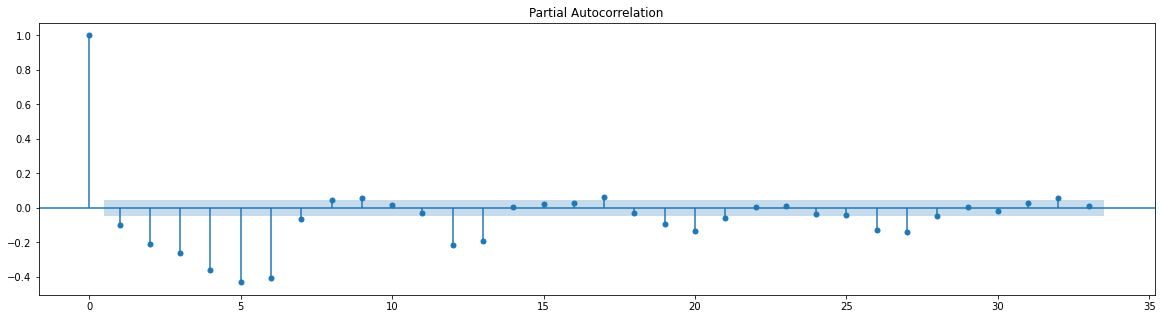

In [156]:
plot_acf(diff)
plot_pacf(diff)

In [73]:
t0 = time.time()
model_name='SARIMA_ca4'
sarima_model = auto_arima(ca1_Series, start_p=0, start_q=0,
                          max_p=5, max_q=5,
                          seasonal=True, m=7,
                          d=None, trace=True,random_state=2020,
                          out_of_sample_size=28,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
sarima_model.summary() 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.79 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=27446.030, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=26973.179, Time=0.82 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=26764.905, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=27444.040, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=27137.938, Time=0.42 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.21 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=26562.573, Time=2.59 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=5.24 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=27120.327, Time=1.10 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=26381.704, Time=3.66 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=26544.353, Time=1.72 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=7.20 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.94 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=27006.1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1913
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 7)   Log Likelihood              -13125.172
Date:                           Sat, 11 Dec 2021   AIC                          26264.345
Time:                                   01:38:49   BIC                          26303.236
Sample:                                        0   HQIC                         26278.657
                                          - 1913                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0092      0.038      0.243      0.808      -0.065       0.083
ar.L1          0.2643      0.034      7.832      0.000       0.198       0.330
ar.L2          0.0033      0.044      0.074      0.941      -0.084       0.090
ma.L1         -0.9777      0.010   -100.460      0.000      -0.997      -0.959
ar.S.L7        0.9779      0.010     94.681      0.000       0.958       0.998
ma.S.L7       -0.8419      0.033    -25.392      0.000      -0.907      -0.777
sigma2      8.692e+04   2107.360     41.245      0.000    8.28e+04     9.1e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):             41440.60
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                            -2.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE for SARIMA_ca4: 225.9348


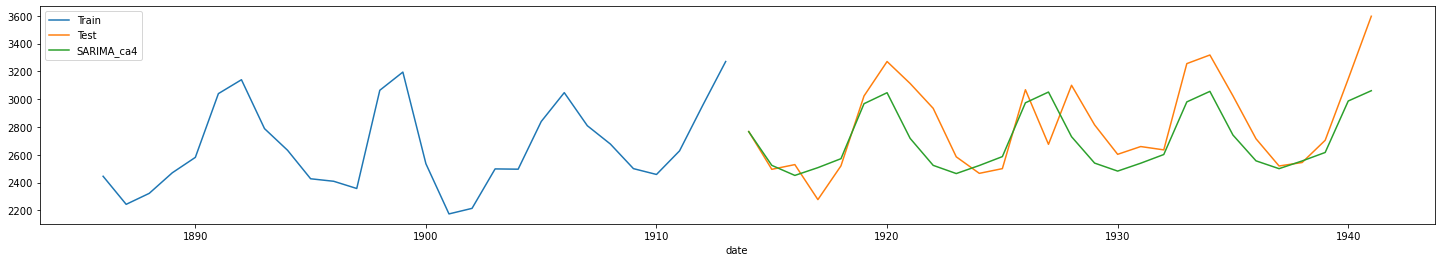

In [74]:
#train
sarima_model.fit(ca1_Series)
t1 = time.time()-t0
#predict
predictions[model_name] = sarima_model.predict(n_periods=28)
#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='index',y='CA_4',label='Train',ax=ax)
test.plot(x='index',y='CA_4',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['CA_4']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)

In [75]:
stats

Model Name  Execution Time       RMSE
0  SARIMA_ca1       138.96155  335.06142
1  SARIMA_ca2       200.47475  427.50246
2  SARIMA_ca3        93.88282 1276.13620
3  SARIMA_ca4       147.63606  225.93484

In [26]:
data_ca4 = train_val[train_val['store_id'] == "CA_4"]
train_data= data_ca4[d_cols[:-28]]
val_data = data_ca4[d_cols[-28:]]

predictions = []
for row in tqdm(train_data[train_data.columns[-28:]].values[:3049]):
    fit = sm.tsa.statespace.SARIMAX(row,order=(2,1,1), seasonal_order=(1, 0, 1, 7)).fit()
    predictions.append(fit.forecast(28))
predictions = np.array(predictions).reshape((-1, 28))

rmse_ca4 = np.sqrt(mean_squared_error(predictions[:3049], val_data.values[:3049]))

  0%|          | 0/3049 [00:00<?, ?it/s]

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

In [24]:
rmse_ca4 = np.sqrt(mean_squared_error(predictions[:3049], val_data.values[:3049]))

In [27]:
rmse_ca4

1.6776154518583577

## TX_1

Test Statistic                -2.69302
p-value                        0.07525
#Lags Used                    26.00000
No of Observesations Used   1886.00000
Critical Value (1%)           -3.43382
Critical Value (5%)           -2.86307
Critical Value (10%)          -2.56759
dtype: float64


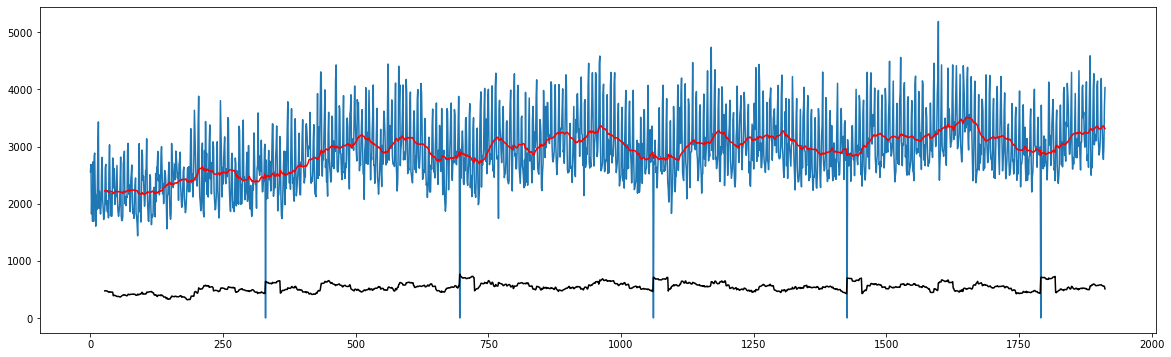

In [151]:
ca1_Series = train['TX_1']
ca1_Series.fillna(0,inplace=True)
test_stationarityDF(ca1_Series)

movingAverage = ca1_Series.rolling(window=28).mean()
movingSTD = ca1_Series.rolling(window=28).std()
plt.figure(figsize=(20,6))
plt.plot(ca1_Series)
plt.plot(movingAverage,color='red')
plt.plot(movingSTD,color='black')
plt.show()

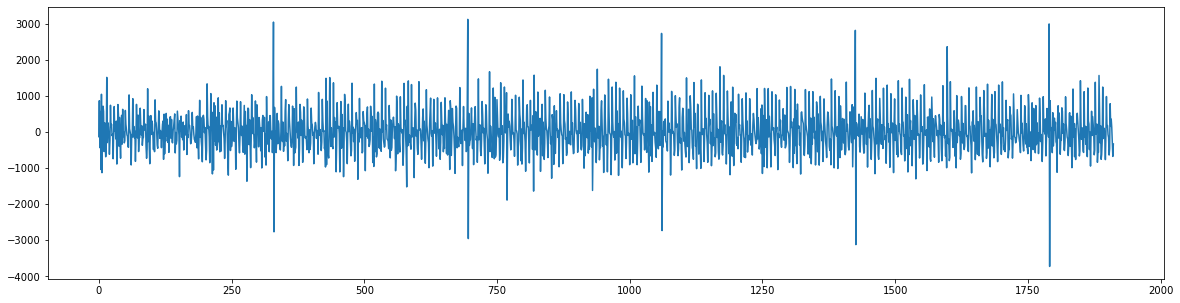

Test Statistic               -20.92544
p-value                        0.00000
#Lags Used                    26.00000
No of Observesations Used   1885.00000
Critical Value (1%)           -3.43382
Critical Value (5%)           -2.86307
Critical Value (10%)          -2.56759
dtype: float64


In [152]:
diff =[ ca1_Series[i]-ca1_Series[i+1] for i in range(len(ca1_Series)-1) ]
diff = pd.DataFrame(diff)
plt.figure(figsize=(20,5))
plt.plot(diff)
plt.show()
pd.set_option('display.float_format', '{:.5f}'.format)
ca1SeriesDiff.fillna(0,inplace=True)
test_stationarityDF(diff)

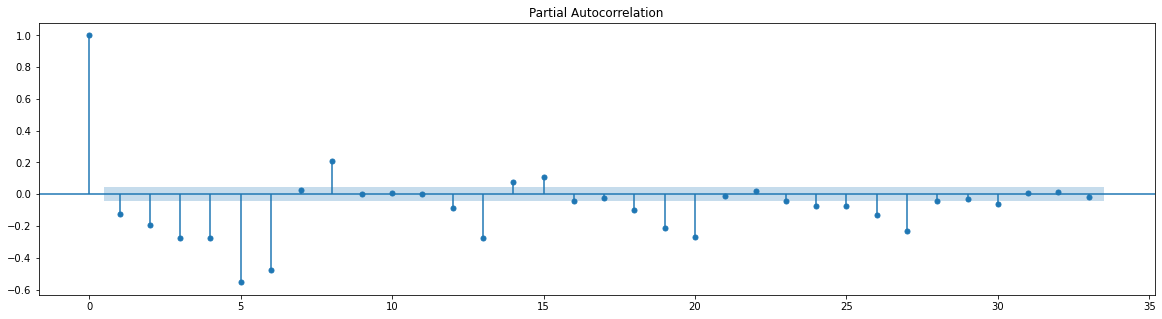

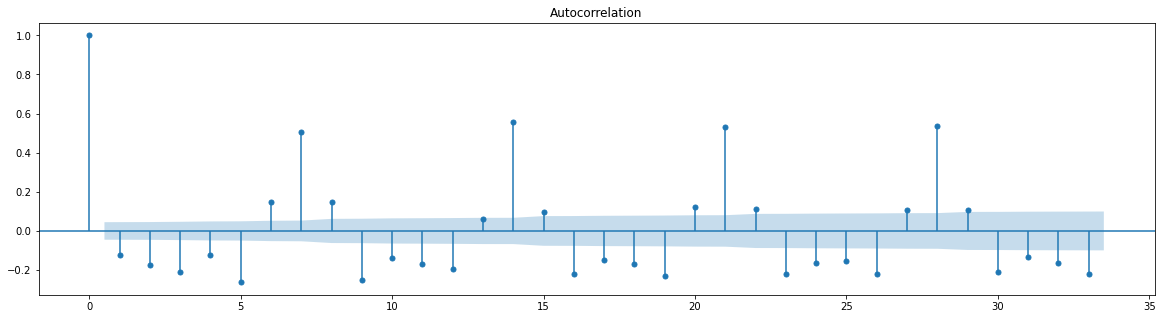

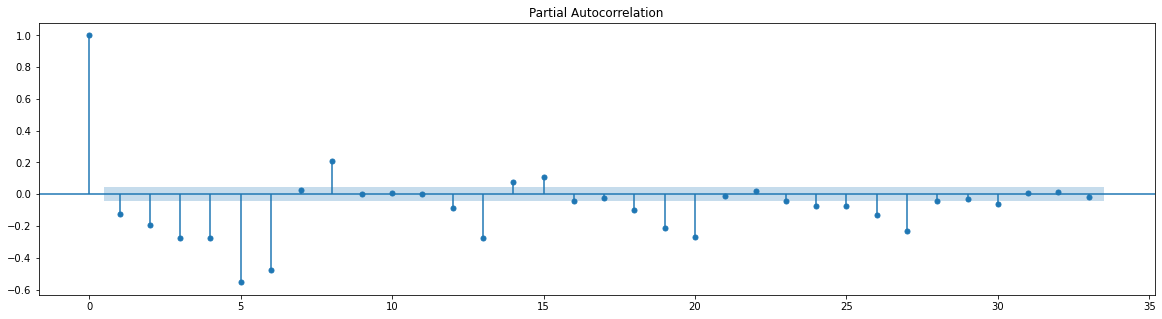

In [153]:
plot_acf(diff)
plot_pacf(diff)

In [79]:
t0 = time.time()
model_name='SARIMA_tx1'
sarima_model = auto_arima(ca1_Series, start_p=0, start_q=0,
                          max_p=5, max_q=5,
                          seasonal=True, m=7,
                          d=None, trace=True,random_state=2020,
                          out_of_sample_size=28,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
sarima_model.summary() 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=29872.250, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=28855.139, Time=0.86 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=28949.930, Time=1.30 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=29870.252, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=29844.977, Time=0.17 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=28499.081, Time=1.51 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.90 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.61 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=28959.028, Time=1.13 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=28446.265, Time=2.17 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=28805.347, Time=1.28 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=5.79 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=3.14 sec
 ARIMA(3,1,0)(2,0,0)[7] intercept   : AIC=28362.1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1913
Model:             SARIMAX(5, 1, 1)x(2, 0, [], 7)   Log Likelihood              -14123.162
Date:                            Sat, 11 Dec 2021   AIC                          28264.324
Time:                                    01:44:10   BIC                          28314.327
Sample:                                         0   HQIC                         28282.726
                                           - 1913                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1316      0.091    -12.461      0.000      -1.310      -0.954
ar.L2         -0.6746      0.063    -10.644      0.000      -0.799      -0.550
ar.L3         -0.4965      0.046    -10.825      0.000      -0.586      -0.407
ar.L4         -0.3646      0.043     -8.539      0.000      -0.448      -0.281
ar.L5         -0.2455      0.023    -10.767      0.000      -0.290      -0.201
ma.L1          0.5197      0.090      5.782      0.000       0.344       0.696
ar.S.L7        0.4571      0.025     18.124      0.000       0.408       0.507
ar.S.L14       0.3211      0.020     16.227      0.000       0.282       0.360
sigma2      1.534e+05   2393.320     64.092      0.000    1.49e+05    1.58e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5462.95
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                            -0.66
Prob(H) (two-sided):                  0.06   Kurtosis:                        11.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE for SARIMA_tx1: 524.0200


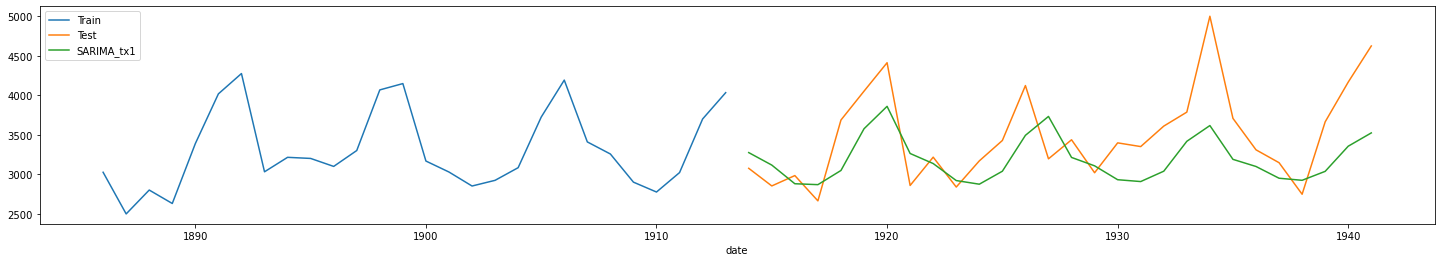

In [80]:
#train
sarima_model.fit(ca1_Series)
t1 = time.time()-t0
#predict
predictions[model_name] = sarima_model.predict(n_periods=28)
#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='index',y='TX_1',label='Train',ax=ax)
test.plot(x='index',y='TX_1',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['TX_1']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)

In [81]:
stats

Model Name  Execution Time       RMSE
0  SARIMA_ca1       138.96155  335.06142
1  SARIMA_ca2       200.47475  427.50246
2  SARIMA_ca3        93.88282 1276.13620
3  SARIMA_ca4       147.63606  225.93484
4  SARIMA_tx1       205.54332  524.01999

In [37]:
data_tx1 = train_val[train_val['store_id'] == "TX_1"]
train_data= data_tx1[d_cols[:-28]]
val_data = data_tx1[d_cols[-28:]]

predictions = []
for row in tqdm(train_data[train_data.columns[-28:]].values[:3049]):
    fit = sm.tsa.statespace.SARIMAX(row,seasonal_order=(2, 0, 0, 7)).fit()
    predictions.append(fit.forecast(28))
predictions = np.array(predictions).reshape((-1, 28))

rmse_tx1 = np.sqrt(mean_squared_error(predictions[:3049], val_data.values[:3049]))

  0%|          | 0/3049 [00:00<?, ?it/s]

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

In [38]:
rmse_tx1

2.3937613364372137

## TX_2

Test Statistic                -2.55370
p-value                        0.10295
#Lags Used                    26.00000
No of Observesations Used   1886.00000
Critical Value (1%)           -3.43382
Critical Value (5%)           -2.86307
Critical Value (10%)          -2.56759
dtype: float64


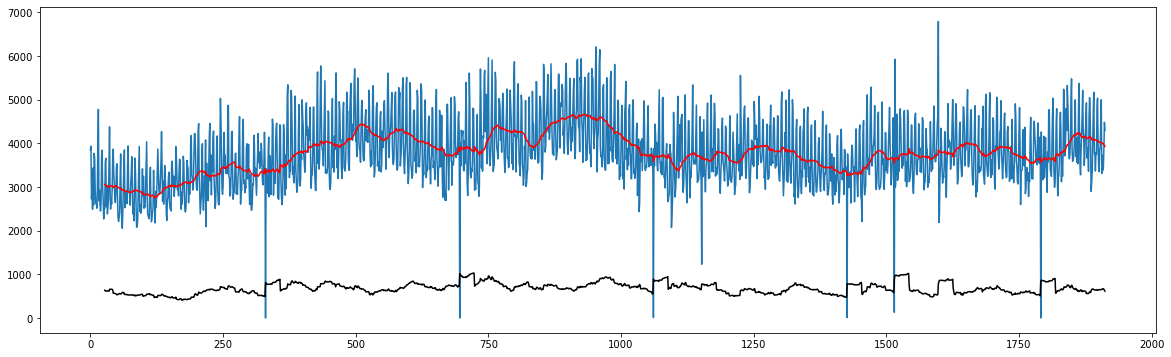

In [148]:
ca1_Series = train['TX_2']
ca1_Series.fillna(0,inplace=True)
test_stationarityDF(ca1_Series)

movingAverage = ca1_Series.rolling(window=28).mean()
movingSTD = ca1_Series.rolling(window=28).std()
plt.figure(figsize=(20,6))
plt.plot(ca1_Series)
plt.plot(movingAverage,color='red')
plt.plot(movingSTD,color='black')
plt.show()

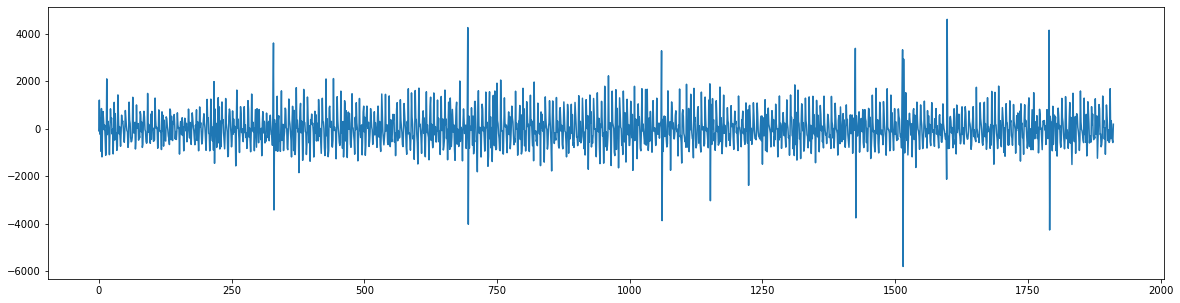

Test Statistic               -18.75209
p-value                        0.00000
#Lags Used                    26.00000
No of Observesations Used   1885.00000
Critical Value (1%)           -3.43382
Critical Value (5%)           -2.86307
Critical Value (10%)          -2.56759
dtype: float64


In [149]:
diff =[ ca1_Series[i]-ca1_Series[i+1] for i in range(len(ca1_Series)-1) ]
diff = pd.DataFrame(diff)
plt.figure(figsize=(20,5))
plt.plot(diff)
plt.show()
pd.set_option('display.float_format', '{:.5f}'.format)
ca1SeriesDiff.fillna(0,inplace=True)
test_stationarityDF(diff)

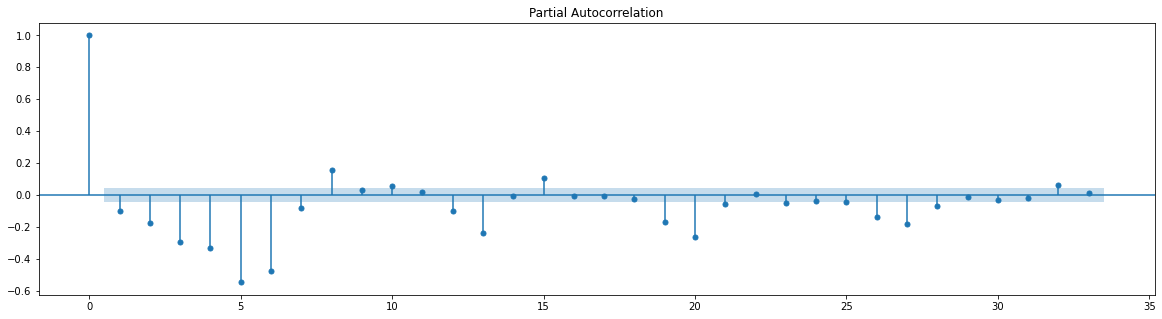

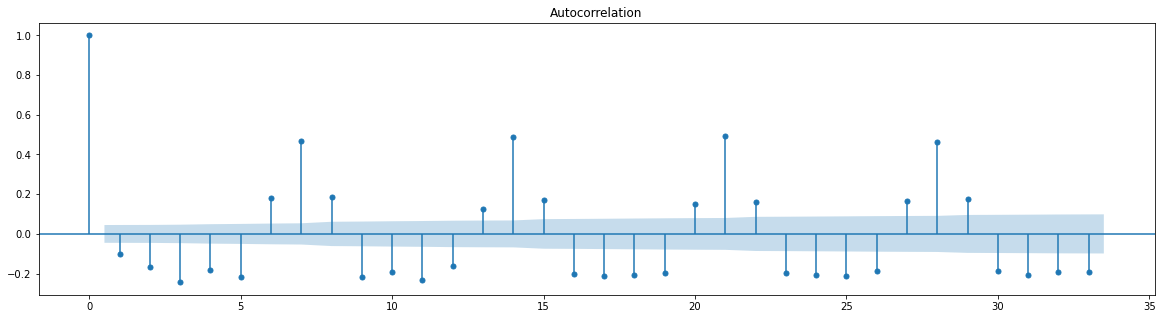

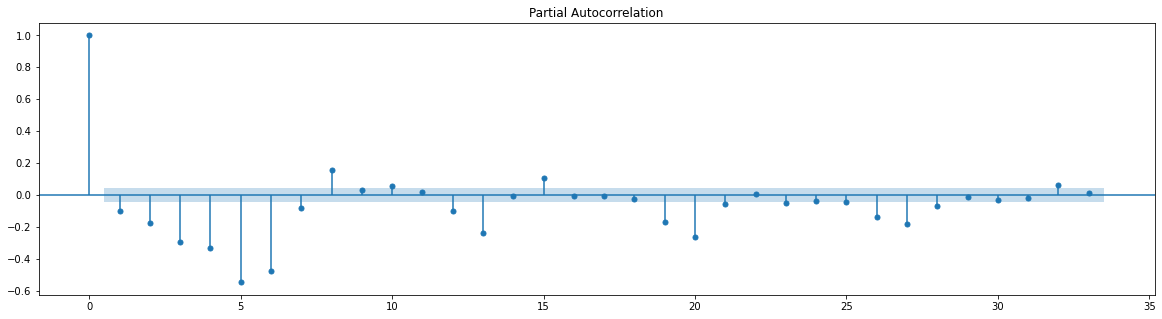

In [150]:
plot_acf(diff)
plot_pacf(diff)

In [85]:
t0 = time.time()
model_name='SARIMA_tx2'
sarima_model = auto_arima(ca1_Series, start_p=0, start_q=0,
                          max_p=5, max_q=5,
                          seasonal=True, m=7,
                          d=None, trace=True,random_state=2020,
                          out_of_sample_size=28,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
sarima_model.summary() 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.03 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=30808.357, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=29938.431, Time=0.90 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=29879.155, Time=1.50 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=30806.354, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=30482.181, Time=0.43 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.54 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=29670.422, Time=3.30 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=2.89 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=30365.573, Time=1.21 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=29561.475, Time=4.14 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=29745.356, Time=2.04 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=6.28 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.57 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=30166.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1913
Model:             SARIMAX(5, 1, 2)x(0, 0, 2, 7)   Log Likelihood              -14517.204
Date:                           Sat, 11 Dec 2021   AIC                          29054.407
Time:                                   01:48:37   BIC                          29109.966
Sample:                                        0   HQIC                         29074.854
                                          - 1913                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4137      0.020     20.415      0.000       0.374       0.453
ar.L2         -0.6312      0.023    -27.592      0.000      -0.676      -0.586
ar.L3         -0.3421      0.025    -13.563      0.000      -0.391      -0.293
ar.L4         -0.2345      0.023    -10.200      0.000      -0.280      -0.189
ar.L5         -0.3456      0.025    -13.700      0.000      -0.395      -0.296
ma.L1         -1.1785      0.014    -81.290      0.000      -1.207      -1.150
ma.L2          0.9010      0.013     66.991      0.000       0.875       0.927
ma.S.L7        0.0752      0.032      2.372      0.018       0.013       0.137
ma.S.L14       0.0198      0.029      0.684      0.494      -0.037       0.076
sigma2      2.484e+05   3944.535     62.973      0.000    2.41e+05    2.56e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):              9286.77
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               1.36   Skew:                            -0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE for SARIMA_tx2: 525.8653


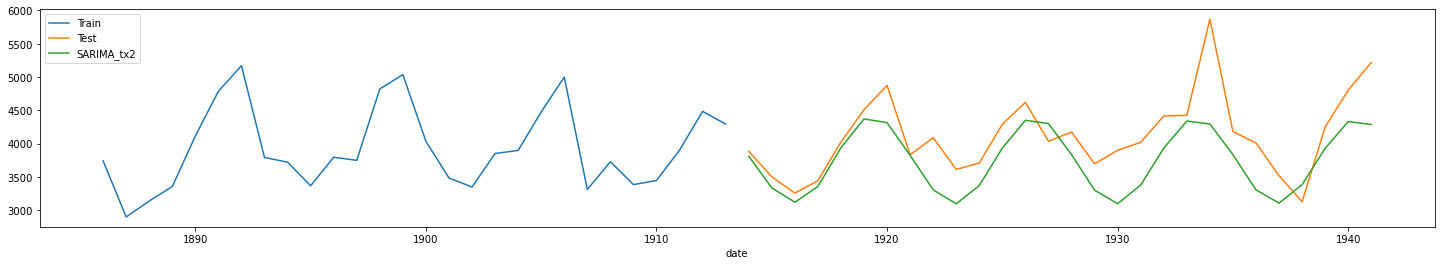

In [86]:
#train
sarima_model.fit(ca1_Series)
t1 = time.time()-t0
#predict
predictions[model_name] = sarima_model.predict(n_periods=28)
#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='index',y='TX_2',label='Train',ax=ax)
test.plot(x='index',y='TX_2',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['TX_2']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)

In [87]:
stats

Model Name  Execution Time       RMSE
0  SARIMA_ca1       138.96155  335.06142
1  SARIMA_ca2       200.47475  427.50246
2  SARIMA_ca3        93.88282 1276.13620
3  SARIMA_ca4       147.63606  225.93484
4  SARIMA_tx1       205.54332  524.01999
5  SARIMA_tx2       218.63751  525.86530

In [35]:
data_tx2 = train_val[train_val['store_id'] == "TX_2"]
train_data= data_tx2[d_cols[:-28]]
val_data = data_tx2[d_cols[-28:]]

predictions = []
for row in tqdm(train_data[train_data.columns[-28:]].values[:3049]):
    fit = sm.tsa.statespace.SARIMAX(row,seasonal_order=(0, 0, 2, 7)).fit()
    predictions.append(fit.forecast(28))
predictions = np.array(predictions).reshape((-1, 28))

rmse_tx2 = np.sqrt(mean_squared_error(predictions[:3049], val_data.values[:3049]))

  0%|          | 0/3049 [00:00<?, ?it/s]

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

In [36]:
rmse_tx2

3.24041174399628

## TX_3

Test Statistic                -2.05797
p-value                        0.26175
#Lags Used                    26.00000
No of Observesations Used   1886.00000
Critical Value (1%)           -3.43382
Critical Value (5%)           -2.86307
Critical Value (10%)          -2.56759
dtype: float64


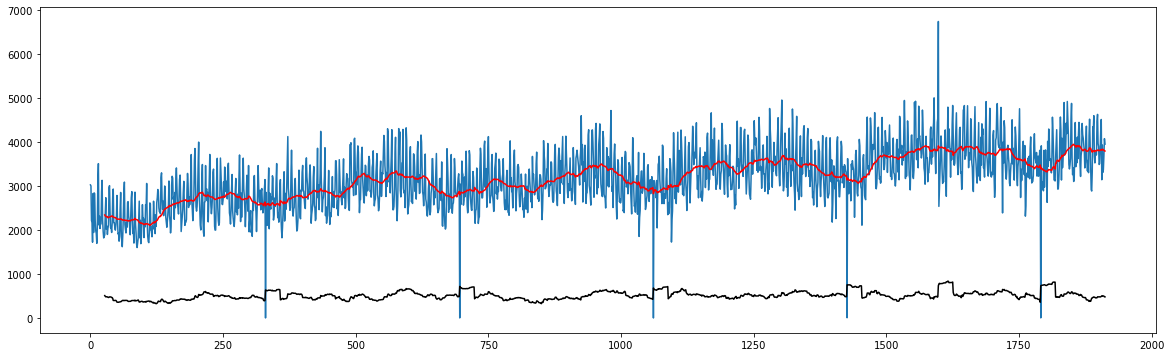

In [145]:
ca1_Series = train['TX_3']
ca1_Series.fillna(0,inplace=True)
test_stationarityDF(ca1_Series)

movingAverage = ca1_Series.rolling(window=28).mean()
movingSTD = ca1_Series.rolling(window=28).std()
plt.figure(figsize=(20,6))
plt.plot(ca1_Series)
plt.plot(movingAverage,color='red')
plt.plot(movingSTD,color='black')
plt.show()

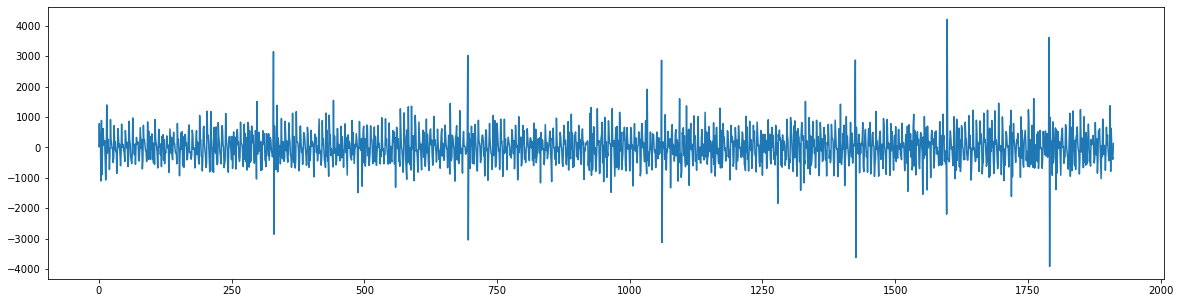

Test Statistic               -19.38191
p-value                        0.00000
#Lags Used                    26.00000
No of Observesations Used   1885.00000
Critical Value (1%)           -3.43382
Critical Value (5%)           -2.86307
Critical Value (10%)          -2.56759
dtype: float64


In [146]:
diff =[ ca1_Series[i]-ca1_Series[i+1] for i in range(len(ca1_Series)-1) ]
diff = pd.DataFrame(diff)
plt.figure(figsize=(20,5))
plt.plot(diff)
plt.show()
pd.set_option('display.float_format', '{:.5f}'.format)
ca1SeriesDiff.fillna(0,inplace=True)
test_stationarityDF(diff)

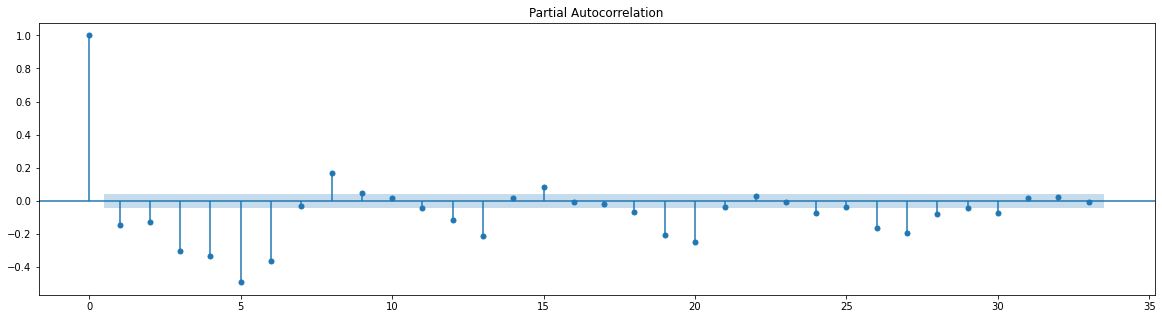

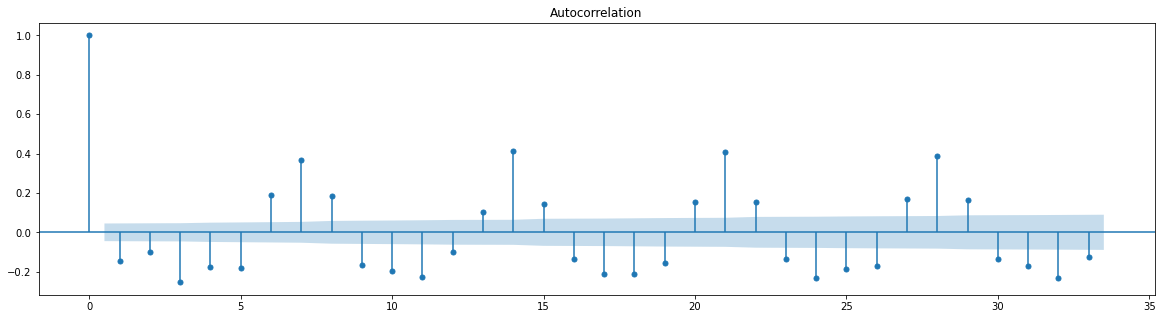

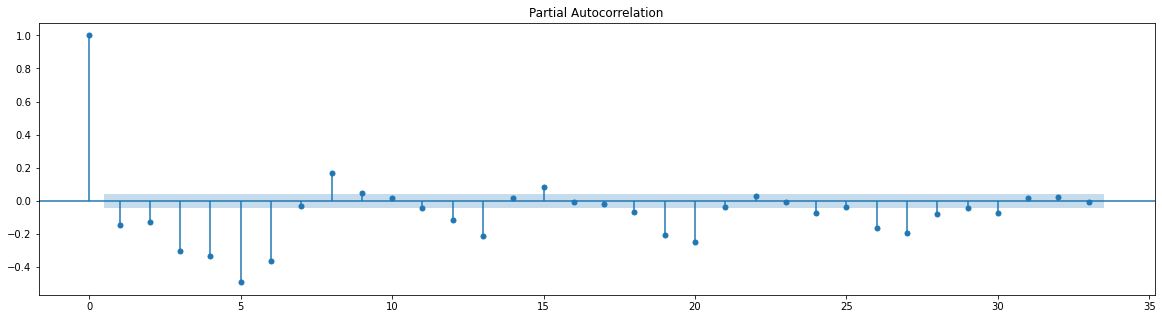

In [147]:
plot_acf(diff)
plot_pacf(diff)

In [91]:
t0 = time.time()
model_name='SARIMA_tx3'
sarima_model = auto_arima(ca1_Series, start_p=0, start_q=0,
                          max_p=5, max_q=5,
                          seasonal=True, m=7,
                          d=None, trace=True,random_state=2020,
                          out_of_sample_size=28,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
sarima_model.summary() 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.48 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=29703.774, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=29083.475, Time=0.91 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=28998.571, Time=1.36 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=29701.774, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=29422.991, Time=0.52 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.74 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=28875.177, Time=3.05 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=5.40 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=29404.451, Time=1.23 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=28694.616, Time=4.29 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=28814.683, Time=2.41 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=5.16 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.92 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=29205.2

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1913
Model:               SARIMAX(5, 1, 3)   Log Likelihood              -14106.309
Date:                Sat, 11 Dec 2021   AIC                          28230.617
Time:                        01:52:15   BIC                          28280.620
Sample:                             0   HQIC                         28249.019
                               - 1913                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0929      0.077     14.199      0.000       0.942       1.244
ar.L2         -0.9805      0.054    -18.305      0.000      -1.085      -0.876
ar.L3          0.0233      0.065      0.360      0.719      -0.104       0.150
ar.L4         -0.1226      0.040     -3.079      0.002      -0.201      -0.045
ar.L5         -0.0395      0.047     -0.836      0.403      -0.132       0.053
ma.L1         -1.7926      0.077    -23.327      0.000      -1.943      -1.642
ma.L2          1.6631      0.093     17.972      0.000       1.482       1.844
ma.L3         -0.5639      0.071     -7.942      0.000      -0.703      -0.425
sigma2      1.643e+05   2514.058     65.343      0.000    1.59e+05    1.69e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.38   Jarque-Bera (JB):             10723.10
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE for SARIMA_tx3: 630.3861


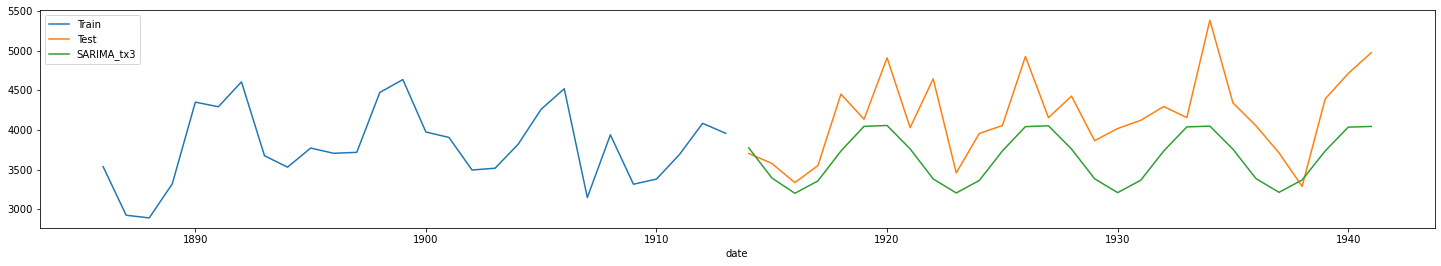

In [92]:
#train
sarima_model.fit(ca1_Series)
t1 = time.time()-t0
#predict
predictions[model_name] = sarima_model.predict(n_periods=28)
#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='index',y='TX_3',label='Train',ax=ax)
test.plot(x='index',y='TX_3',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['TX_3']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)

In [93]:
stats

Model Name  Execution Time       RMSE
0  SARIMA_ca1       138.96155  335.06142
1  SARIMA_ca2       200.47475  427.50246
2  SARIMA_ca3        93.88282 1276.13620
3  SARIMA_ca4       147.63606  225.93484
4  SARIMA_tx1       205.54332  524.01999
5  SARIMA_tx2       218.63751  525.86530
6  SARIMA_tx3       306.53072  630.38613

In [71]:
data_tx3 = train_val[train_val['store_id'] == "TX_3"]
train_data= data_tx3[d_cols[:-28]]
val_data = data_tx3[d_cols[-28:]]

predictions = []
for row in tqdm(train_data[train_data.columns[-28:]].values[:3049]):
    fit = sm.tsa.statespace.SARIMAX(row,seasonal_order=(0, 0, 0, 7)).fit()
    predictions.append(fit.forecast(28))
predictions = np.array(predictions).reshape((-1, 28))

rmse_tx3 = np.sqrt(mean_squared_error(predictions[:3049], val_data.values[:3049]))

  0%|          | 0/3049 [00:00<?, ?it/s]

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

In [72]:
rmse_tx3

3.224074173402028

## WI_1

Test Statistic                -1.23550
p-value                        0.65814
#Lags Used                    26.00000
No of Observesations Used   1886.00000
Critical Value (1%)           -3.43382
Critical Value (5%)           -2.86307
Critical Value (10%)          -2.56759
dtype: float64


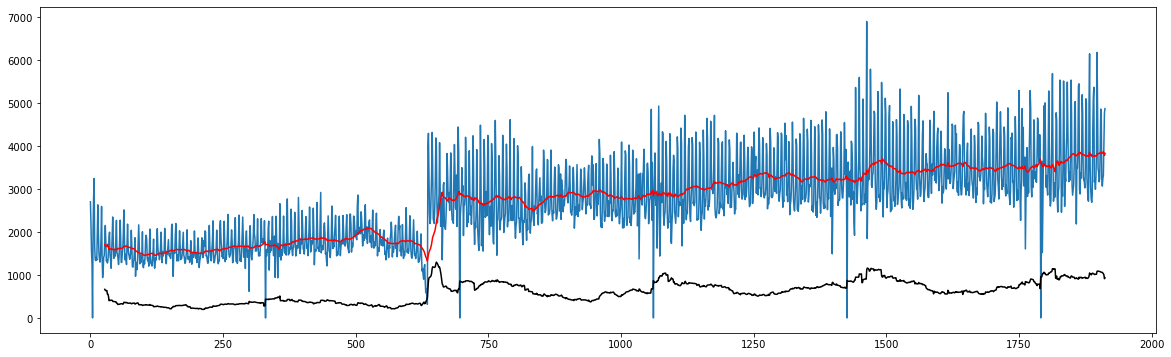

In [142]:
ca1_Series = train['WI_1']
ca1_Series.fillna(0,inplace=True)
test_stationarityDF(ca1_Series)

movingAverage = ca1_Series.rolling(window=28).mean()
movingSTD = ca1_Series.rolling(window=28).std()
plt.figure(figsize=(20,6))
plt.plot(ca1_Series)
plt.plot(movingAverage,color='red')
plt.plot(movingSTD,color='black')
plt.show()

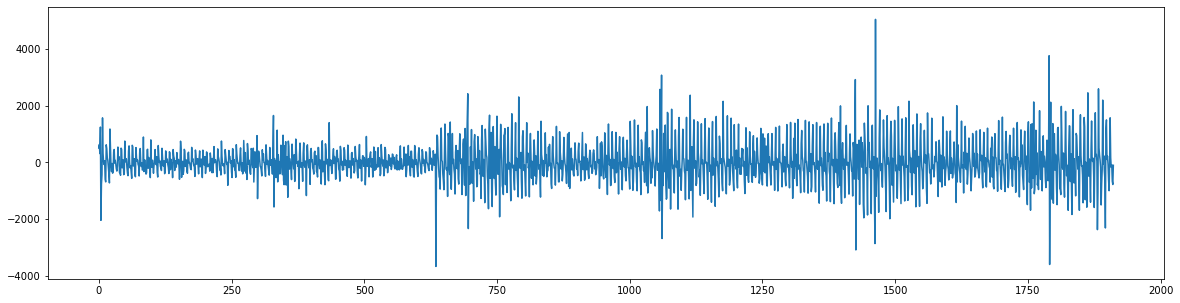

Test Statistic               -15.11462
p-value                        0.00000
#Lags Used                    26.00000
No of Observesations Used   1885.00000
Critical Value (1%)           -3.43382
Critical Value (5%)           -2.86307
Critical Value (10%)          -2.56759
dtype: float64


In [143]:
diff =[ ca1_Series[i]-ca1_Series[i+1] for i in range(len(ca1_Series)-1) ]
diff = pd.DataFrame(diff)
plt.figure(figsize=(20,5))
plt.plot(diff)
plt.show()
pd.set_option('display.float_format', '{:.5f}'.format)
ca1SeriesDiff.fillna(0,inplace=True)
test_stationarityDF(diff)

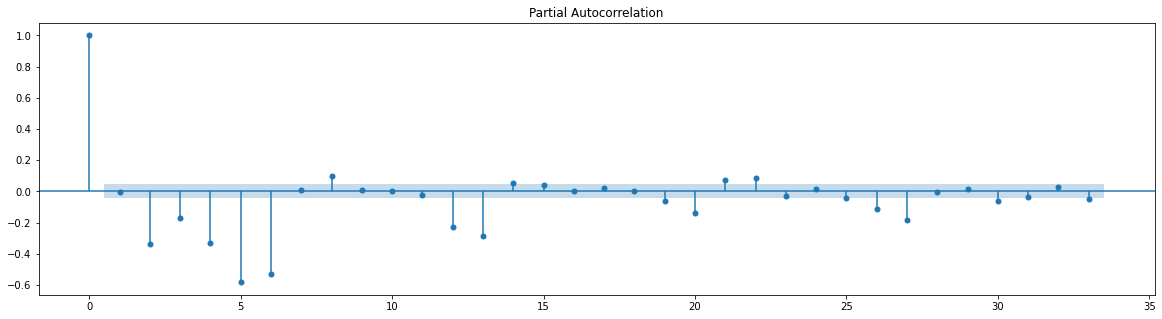

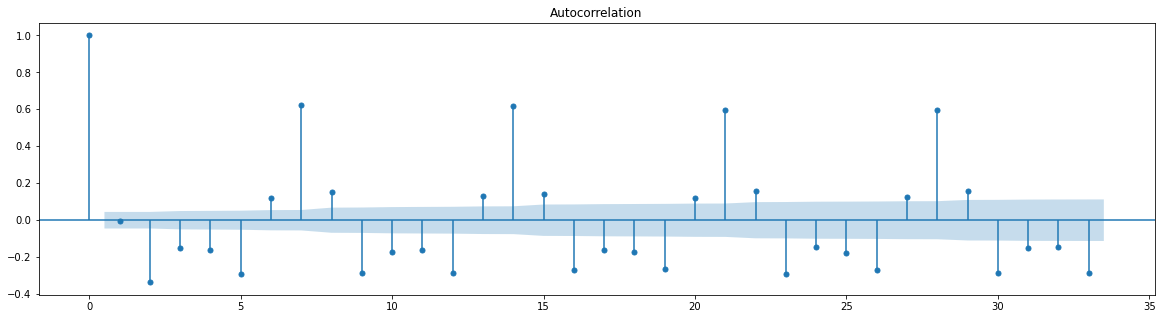

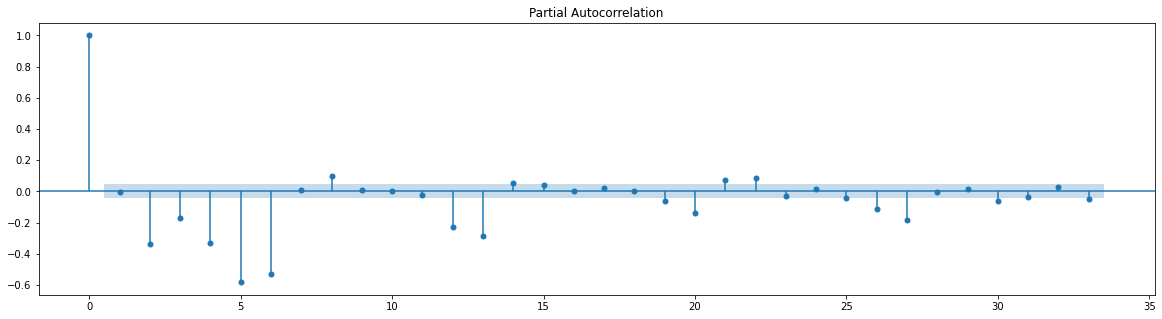

In [144]:
plot_acf(diff)
plot_pacf(diff)

In [97]:
t0 = time.time()
model_name='SARIMA_wi1'
sarima_model = auto_arima(ca1_Series, start_p=0, start_q=0,
                          max_p=5, max_q=5,
                          seasonal=True, m=7,
                          d=None, trace=True,random_state=2020,
                          out_of_sample_size=28,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
sarima_model.summary() 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=28995.615, Time=2.34 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=30573.700, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=29421.527, Time=1.24 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=29615.367, Time=1.49 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=30571.709, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=30067.083, Time=0.53 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=29621.808, Time=0.47 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=29034.300, Time=2.11 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=28995.924, Time=3.88 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=29798.776, Time=1.08 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=29322.546, Time=1.22 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=2.64 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=28760.454, Time=1.72 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=30033.059, Time=0.90 sec
 ARIMA(1,1,0)(2,0,1)[7] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1913
Model:             SARIMAX(3, 1, 0)x(1, 0, [1], 7)   Log Likelihood              -14229.050
Date:                             Sat, 11 Dec 2021   AIC                          28472.100
Time:                                     01:56:32   BIC                          28510.992
Sample:                                          0   HQIC                         28486.413
                                            - 1913                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.198     -0.001      0.999      -0.389       0.388
ar.L1         -0.5622      0.013    -43.190      0.000      -0.588      -0.537
ar.L2         -0.4270      0.016    -26.254      0.000      -0.459      -0.395
ar.L3         -0.2080      0.016    -12.776      0.000      -0.240      -0.176
ar.S.L7        1.0000   1.32e-06   7.56e+05      0.000       1.000       1.000
ma.S.L7       -0.8589      0.010    -86.111      0.000      -0.878      -0.839
sigma2      1.655e+05   5.98e-07   2.77e+11      0.000    1.66e+05    1.66e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.83   Jarque-Bera (JB):             27744.06
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               3.60   Skew:                            -1.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.1e+26. Standard errors may be unstable.
"""

RMSE for SARIMA_wi1: 422.3300


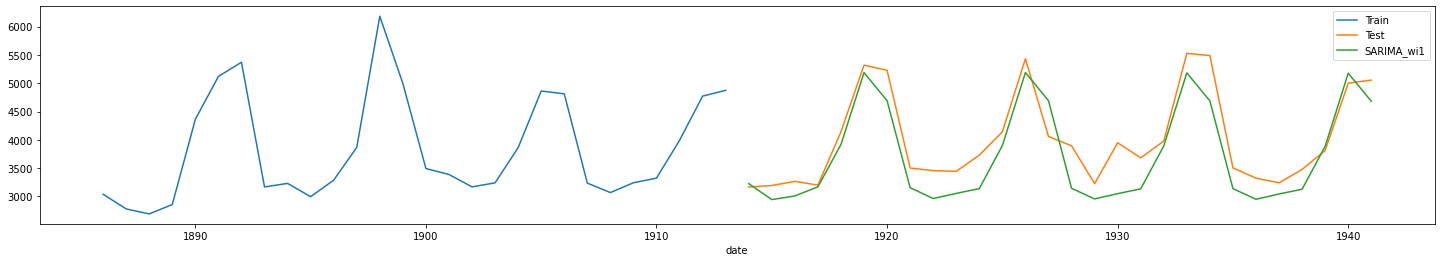

In [98]:
#train
sarima_model.fit(ca1_Series)
t1 = time.time()-t0
#predict
predictions[model_name] = sarima_model.predict(n_periods=28)
#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='index',y='WI_1',label='Train',ax=ax)
test.plot(x='index',y='WI_1',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['WI_1']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)

In [99]:
stats

Model Name  Execution Time       RMSE
0  SARIMA_ca1       138.96155  335.06142
1  SARIMA_ca2       200.47475  427.50246
2  SARIMA_ca3        93.88282 1276.13620
3  SARIMA_ca4       147.63606  225.93484
4  SARIMA_tx1       205.54332  524.01999
5  SARIMA_tx2       218.63751  525.86530
6  SARIMA_tx3       306.53072  630.38613
7  SARIMA_wi1       401.67558  422.32995

In [54]:
data_wi1 = train_val[train_val['store_id'] == "WI_1"]
train_data= data_wi1[d_cols[:-28]]
val_data = data_wi1[d_cols[-28:]]

predictions = []
for row in tqdm(train_data[train_data.columns[-28:]].values[:3049]):
    fit = sm.tsa.statespace.SARIMAX(row,seasonal_order=(1, 0, 1, 7)).fit()
    predictions.append(fit.forecast(28))
predictions = np.array(predictions).reshape((-1, 28))

rmse_wi1 = np.sqrt(mean_squared_error(predictions[:3049], val_data.values[:3049]))

  0%|          | 0/3049 [00:00<?, ?it/s]

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

In [55]:
rmse_wi1

2.180753232524865

## WI_2

Test Statistic                -0.98503
p-value                        0.75868
#Lags Used                    26.00000
No of Observesations Used   1886.00000
Critical Value (1%)           -3.43382
Critical Value (5%)           -2.86307
Critical Value (10%)          -2.56759
dtype: float64


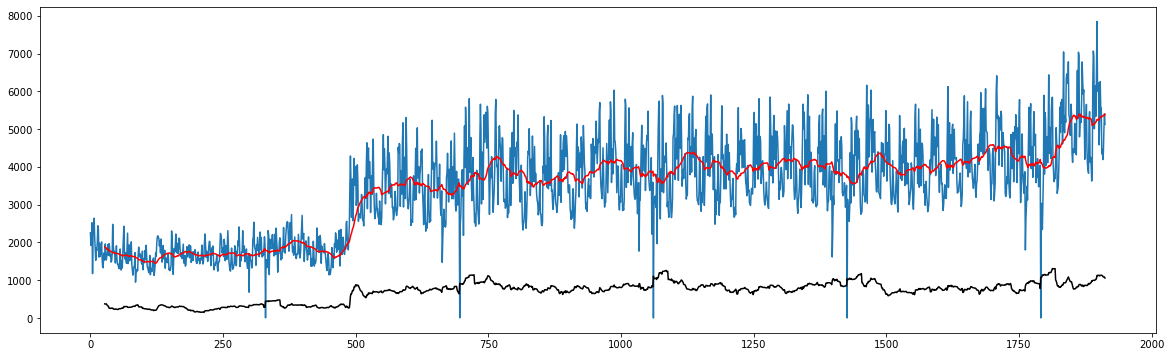

In [139]:
ca1_Series = train['WI_2']
ca1_Series.fillna(0,inplace=True)
test_stationarityDF(ca1_Series)

movingAverage = ca1_Series.rolling(window=28).mean()
movingSTD = ca1_Series.rolling(window=28).std()
plt.figure(figsize=(20,6))
plt.plot(ca1_Series)
plt.plot(movingAverage,color='red')
plt.plot(movingSTD,color='black')
plt.show()

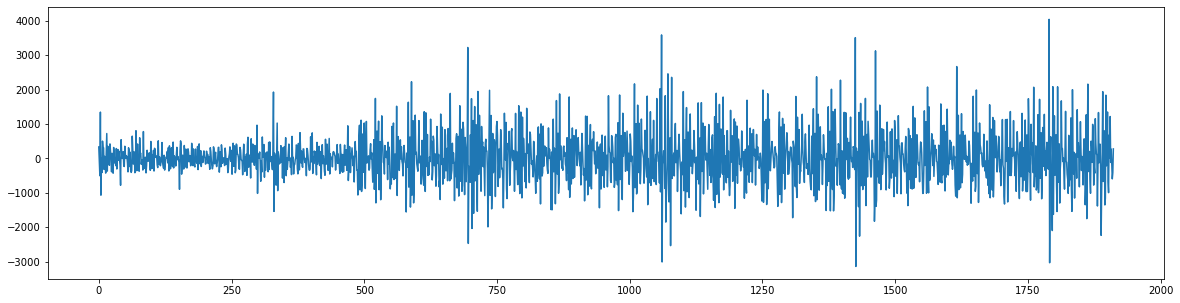

Test Statistic               -25.98034
p-value                        0.00000
#Lags Used                    26.00000
No of Observesations Used   1885.00000
Critical Value (1%)           -3.43382
Critical Value (5%)           -2.86307
Critical Value (10%)          -2.56759
dtype: float64


In [140]:
diff =[ ca1_Series[i]-ca1_Series[i+1] for i in range(len(ca1_Series)-1) ]
diff = pd.DataFrame(diff)
plt.figure(figsize=(20,5))
plt.plot(diff)
plt.show()
pd.set_option('display.float_format', '{:.5f}'.format)
ca1SeriesDiff.fillna(0,inplace=True)
test_stationarityDF(diff)

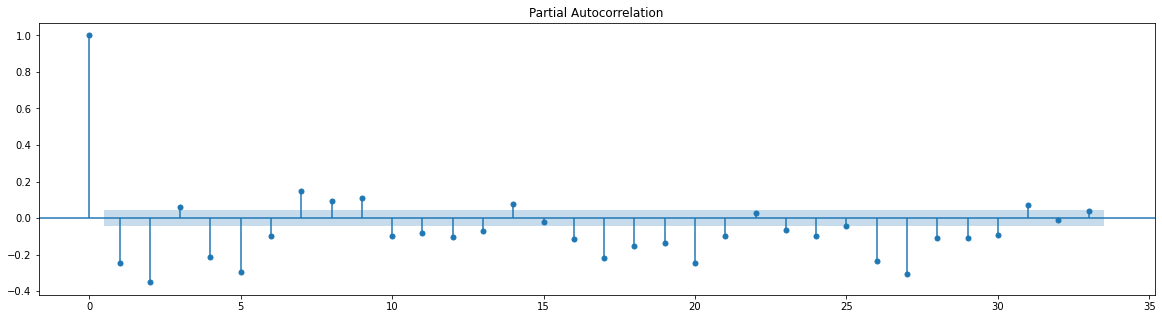

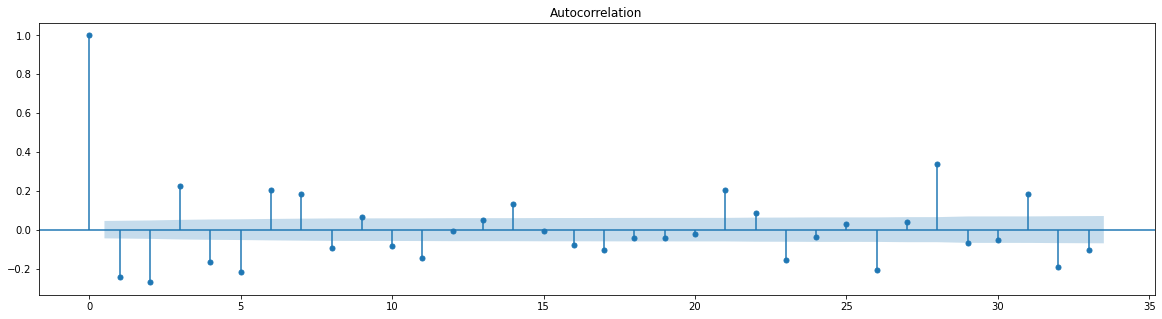

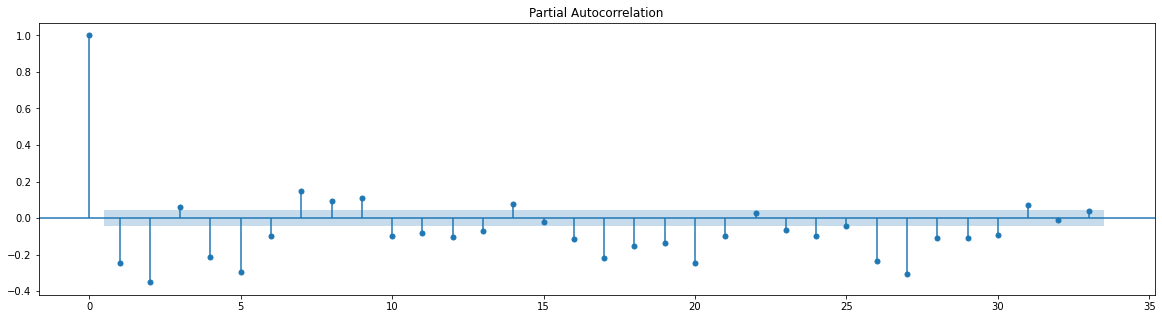

In [141]:
plot_acf(diff)
plot_pacf(diff)

In [103]:
t0 = time.time()
model_name='SARIMA_wi2'
sarima_model = auto_arima(ca1_Series, start_p=0, start_q=0,
                          max_p=5, max_q=5,
                          seasonal=True, m=7,
                          d=None, trace=True,random_state=2020,
                          out_of_sample_size=28,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
sarima_model.summary() 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=30587.337, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=30365.549, Time=0.47 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=30205.920, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=30585.299, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=30316.089, Time=0.57 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.55 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=30200.204, Time=1.81 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=4.87 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=30527.627, Time=0.71 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=30075.251, Time=3.56 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=30073.969, Time=1.61 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=30152.360, Time=0.83 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.44 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=3

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1913
Model:             SARIMAX(5, 1, 0)x(2, 0, 0, 7)   Log Likelihood              -14938.628
Date:                           Sat, 11 Dec 2021   AIC                          29893.256
Time:                                   02:03:55   BIC                          29937.703
Sample:                                        0   HQIC                         29909.613
                                          - 1913                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3641      0.017    -20.833      0.000      -0.398      -0.330
ar.L2         -0.3620      0.020    -18.468      0.000      -0.400      -0.324
ar.L3         -0.0093      0.021     -0.435      0.663      -0.051       0.033
ar.L4         -0.2319      0.022    -10.345      0.000      -0.276      -0.188
ar.L5         -0.2098      0.019    -11.052      0.000      -0.247      -0.173
ar.S.L7        0.2031      0.022      9.117      0.000       0.159       0.247
ar.S.L14       0.0739      0.023      3.262      0.001       0.029       0.118
sigma2      3.673e+05   8105.561     45.313      0.000    3.51e+05    3.83e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               811.41
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               3.83   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE for SARIMA_wi2: 1272.7411


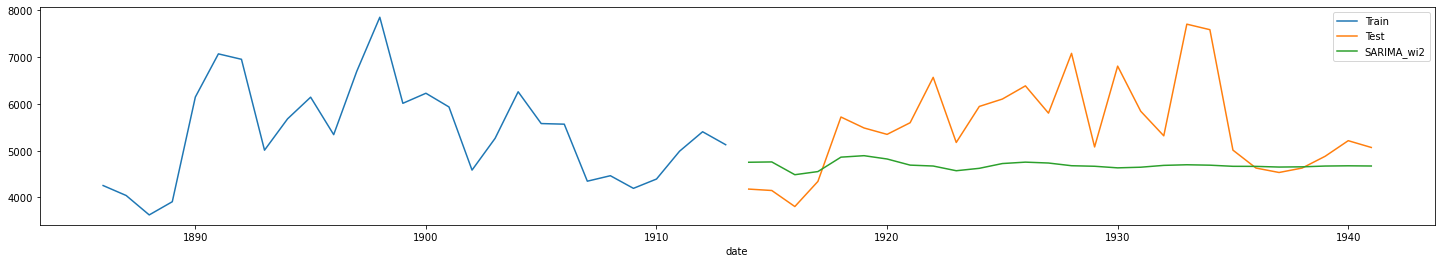

In [104]:
#train
sarima_model.fit(ca1_Series)
t1 = time.time()-t0
#predict
predictions[model_name] = sarima_model.predict(n_periods=28)
#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='index',y='WI_2',label='Train',ax=ax)
test.plot(x='index',y='WI_2',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['WI_2']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)

In [105]:
stats

Model Name  Execution Time       RMSE
0  SARIMA_ca1       138.96155  335.06142
1  SARIMA_ca2       200.47475  427.50246
2  SARIMA_ca3        93.88282 1276.13620
3  SARIMA_ca4       147.63606  225.93484
4  SARIMA_tx1       205.54332  524.01999
5  SARIMA_tx2       218.63751  525.86530
6  SARIMA_tx3       306.53072  630.38613
7  SARIMA_wi1       401.67558  422.32995
8  SARIMA_wi2       171.06266 1272.74108

In [56]:
data_wi2 = train_val[train_val['store_id'] == "WI_2"]
train_data= data_wi2[d_cols[:-28]]
val_data = data_wi2[d_cols[-28:]]

predictions = []
for row in tqdm(train_data[train_data.columns[-28:]].values[:3049]):
    fit = sm.tsa.statespace.SARIMAX(row, seasonal_order=(2, 0, 0, 7)).fit()
    predictions.append(fit.forecast(28))
predictions = np.array(predictions).reshape((-1, 28))

rmse_wi2 = np.sqrt(mean_squared_error(predictions[:3049], val_data.values[:3049]))

  0%|          | 0/3049 [00:00<?, ?it/s]

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

In [57]:
rmse_wi2

4.3799760183815994

## WI_3

Test Statistic                -2.21324
p-value                        0.20148
#Lags Used                    26.00000
No of Observesations Used   1886.00000
Critical Value (1%)           -3.43382
Critical Value (5%)           -2.86307
Critical Value (10%)          -2.56759
dtype: float64


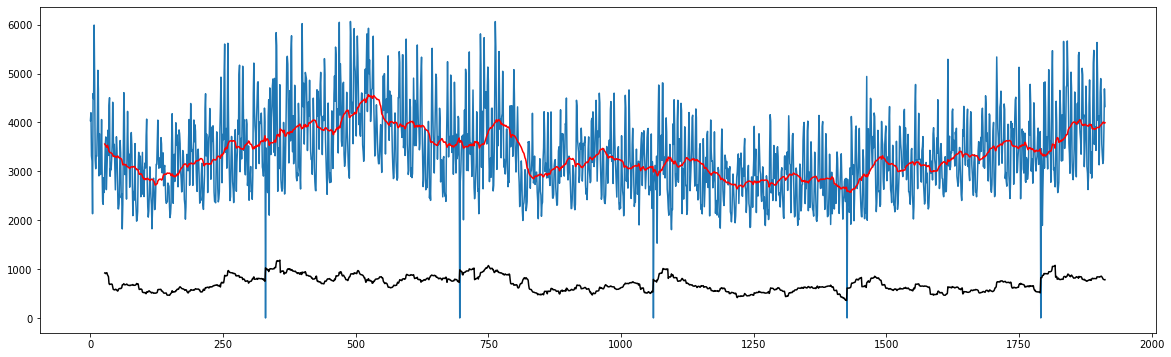

In [106]:
ca1_Series = train['WI_3']
ca1_Series.fillna(0,inplace=True)
test_stationarityDF(ca1_Series)

movingAverage = ca1_Series.rolling(window=28).mean()
movingSTD = ca1_Series.rolling(window=28).std()
plt.figure(figsize=(20,6))
plt.plot(ca1_Series)
plt.plot(movingAverage,color='red')
plt.plot(movingSTD,color='black')
plt.show()

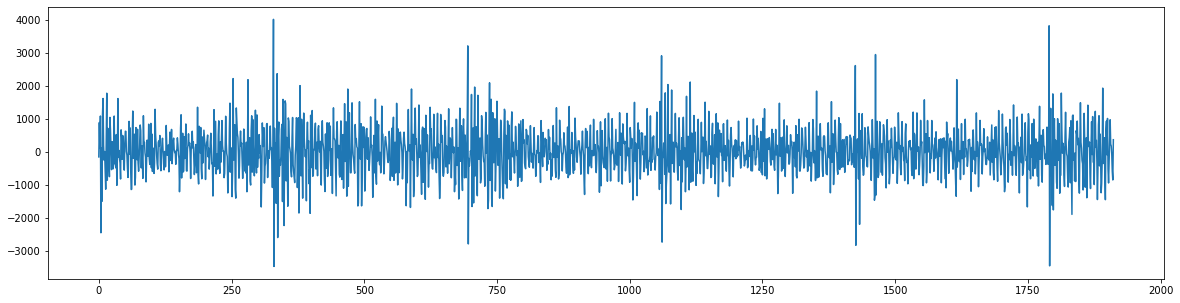

Test Statistic               -25.15798
p-value                        0.00000
#Lags Used                    26.00000
No of Observesations Used   1885.00000
Critical Value (1%)           -3.43382
Critical Value (5%)           -2.86307
Critical Value (10%)          -2.56759
dtype: float64


In [120]:
diff =[ ca1_Series[i]-ca1_Series[i+1] for i in range(len(ca1_Series)-1) ]
diff = pd.DataFrame(diff)
plt.figure(figsize=(20,5))
plt.plot(diff)
plt.show()
pd.set_option('display.float_format', '{:.5f}'.format)
ca1SeriesDiff.fillna(0,inplace=True)
test_stationarityDF(diff)

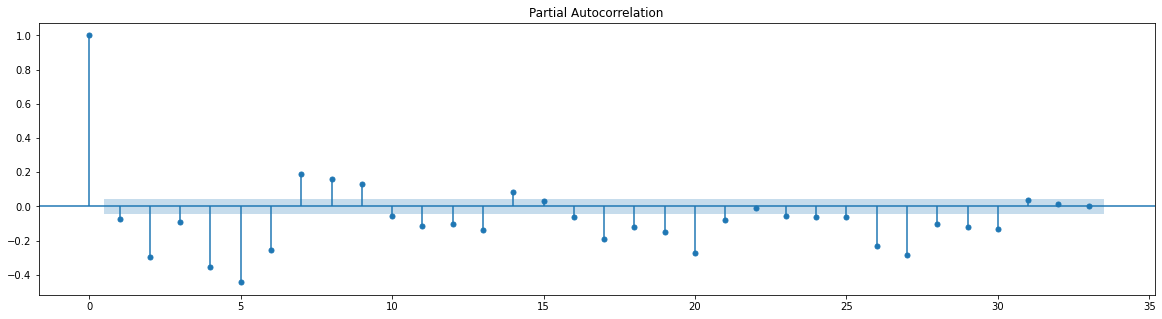

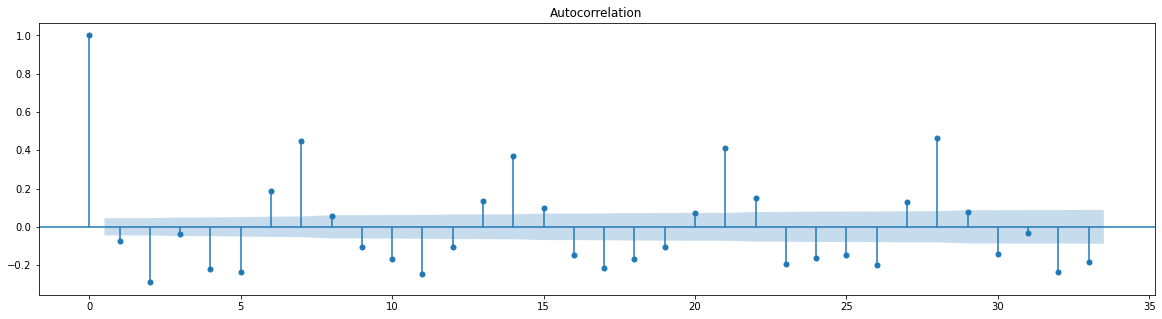

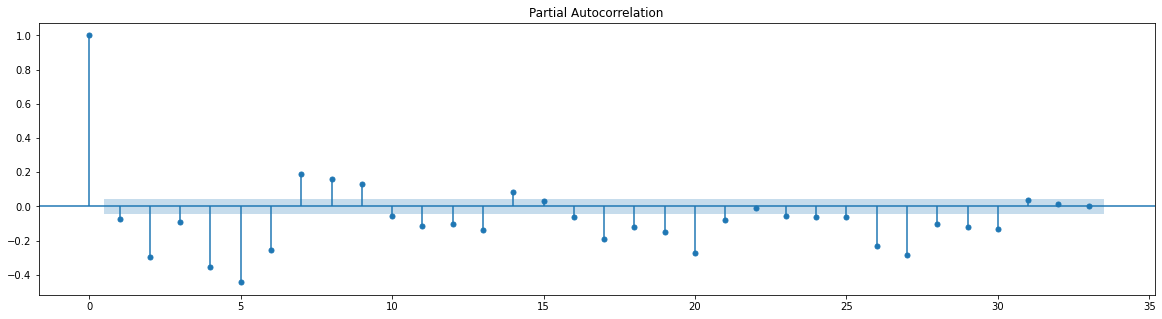

In [118]:
plot_acf(diff)
plot_pacf(diff)

In [109]:
t0 = time.time()
model_name='SARIMA_wi3'
sarima_model = auto_arima(ca1_Series, start_p=0, start_q=0,
                          max_p=5, max_q=5,
                          seasonal=True, m=7,
                          d=None, trace=True,random_state=2020,
                          out_of_sample_size=28,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)
sarima_model.summary() 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.71 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=30551.748, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=29989.704, Time=0.85 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=30070.871, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=30549.751, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=30543.738, Time=0.17 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=29880.774, Time=1.58 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.81 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.12 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=30029.970, Time=1.19 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=29611.677, Time=2.17 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=29751.922, Time=1.13 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=4.95 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=4.75 sec
 ARIMA(3,1,0)(2,0,0)[7] intercept   : AIC=29604.3

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1913
Model:             SARIMAX(4, 1, 2)x(2, 0, [], 7)   Log Likelihood              -14627.424
Date:                            Sat, 11 Dec 2021   AIC                          29272.849
Time:                                    02:08:37   BIC                          29322.852
Sample:                                         0   HQIC                         29291.251
                                           - 1913                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7264      0.019     37.352      0.000       0.688       0.765
ar.L2         -0.8290      0.027    -31.078      0.000      -0.881      -0.777
ar.L3          0.0784      0.026      2.989      0.003       0.027       0.130
ar.L4         -0.4755      0.018    -26.008      0.000      -0.511      -0.440
ma.L1         -1.2171      0.009   -142.022      0.000      -1.234      -1.200
ma.L2          0.9708      0.009    109.976      0.000       0.954       0.988
ar.S.L7        0.2218      0.026      8.380      0.000       0.170       0.274
ar.S.L14       0.0140      0.028      0.499      0.618      -0.041       0.069
sigma2       2.97e+05   6262.001     47.434      0.000    2.85e+05    3.09e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.12   Jarque-Bera (JB):              2094.15
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.25
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

RMSE for SARIMA_wi3: 671.3930


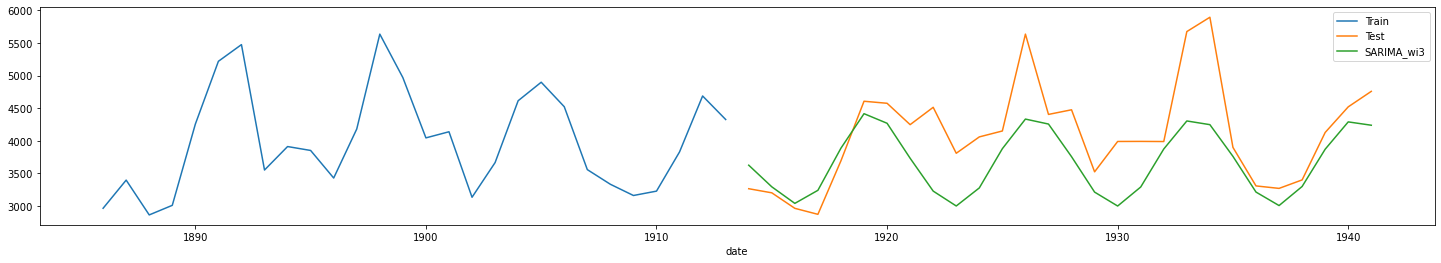

In [110]:
#train
sarima_model.fit(ca1_Series)
t1 = time.time()-t0
#predict
predictions[model_name] = sarima_model.predict(n_periods=28)
#visualize
fig, ax = plt.subplots(figsize=(25,4))
train[-28:].plot(x='index',y='WI_3',label='Train',ax=ax)
test.plot(x='index',y='WI_3',label='Test',ax=ax);
predictions.plot(x='date',y=model_name,label=model_name,ax=ax);
#evaluate
score = np.sqrt(mean_squared_error(predictions[model_name].values, test['WI_3']))
print('RMSE for {}: {:.4f}'.format(model_name,score))

stats = stats.append({'Model Name':model_name, 'Execution Time':t1, 'RMSE':score},ignore_index=True)

In [111]:
stats

Model Name  Execution Time       RMSE
0  SARIMA_ca1       138.96155  335.06142
1  SARIMA_ca2       200.47475  427.50246
2  SARIMA_ca3        93.88282 1276.13620
3  SARIMA_ca4       147.63606  225.93484
4  SARIMA_tx1       205.54332  524.01999
5  SARIMA_tx2       218.63751  525.86530
6  SARIMA_tx3       306.53072  630.38613
7  SARIMA_wi1       401.67558  422.32995
8  SARIMA_wi2       171.06266 1272.74108
9  SARIMA_wi3       247.31957  671.39299

In [61]:
data_wi3 = train_val[train_val['store_id'] == "WI_3"]
train_data= data_wi3[d_cols[:-28]]
val_data = data_wi3[d_cols[-28:]]

predictions = []
for row in tqdm(train_data[train_data.columns[-28:]].values[:3049]):
    fit = sm.tsa.statespace.SARIMAX(row,seasonal_order=(1, 0, 0, 7)).fit()
    predictions.append(fit.forecast(28))
predictions = np.array(predictions).reshape((-1, 28))

rmse_wi3 = np.sqrt(mean_squared_error(predictions[:3049], val_data.values[:3049]))

  0%|          | 0/3049 [00:00<?, ?it/s]

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/tianxinyu/opt/anaconda3/lib/p

In [62]:
rmse_wi3

3.081579426581218